## Text mining with scientific literatures about COVID-19

### Problem Statement
* Litertures can provide insight for researchers since it has the most recent technology or idea included.
* A large number of papers have been published in the recent months due to the break of COVID-19. It is inefficient for scientist to read many papers manually at a short time to get valuable information about COVID-19. This project aims to develop a method to extract important information from a large number of literatures using text mining.

### Challenges
* **Challenges:** The pdf format is not friendly for text mining since it is not easy to clean
    
* **Keywords:**  Clustering, Text mining, Nature language process, Topic modeling
	

### Required packages

In [1]:
import pandas as pd
import nltk
import glob
from nltk import tokenize
import re
from string import digits
from nltk.corpus import stopwords
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import KMeans
import os
import matplotlib as mpl
from sklearn.manifold import MDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities 
import string
from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial.distance import cdist

unable to import 'smart_open.gcs', disabling that module


### Data Preprocessing

#### 1.read files

In [2]:
## file path
file_path="...\\cov_txt\\*.txt"
cov_files = glob.glob(file_path)
## read the file
def read_files(files):
    file_ls=[]
    for file in cov_files:
        with open(file,encoding="utf8") as f:
            f1=(" ".join(line.strip() for line in f))
            file_ls.append(f1)
    return file_ls
cov_txt=read_files(cov_files)
## check the file
print(len(cov_txt))
## 56 correct

56


In [35]:
## check the first file
cov_txt[0]

'The federal government should offer significant assistance to small- and mid-sized service sector businesses so that they can retain their workers. Financial assistance to small business is financial support to workers, allowing workers to continue being paid by their employers during the coronavirus crisis. The goal should be to replace a large portion of the revenue (not just the payroll expenses) those businesses would have generated in the absence of being shut down due to the coronavirus. Low-margin businesses will face great financial difficulty losing multiple months of revenue, and many if not most small businesses would rather shut down or lay off a significant fraction of their workforce than take out a loan, even with a favorable or zero interest rate. The number of potential layoffs the U.S. economy is facing is deeply troubling, and an aggressive policy response is urgently needed. We estimate the cost of replacing 80 percent of the revenue for three months of private-sec

#### 2. Data cleaning

In [3]:
# clean files, including converting to lower case, removing special symbols
text = []
def clean(txt):    
    for file in txt:
        ## lower
        file= file.lower()
        ## remove digits
        remove_digits = str.maketrans('', '', digits)
        file = file.translate(remove_digits)
        ## remove symbol
        file = re.sub('[^A-Za-z0-9]+', " ", file)
        file = file.replace(',', ' ')
        file = file.replace('.', ' ')
        file = file.replace('(', ' ')
        file = file.replace(')', ' ')
        file = file.replace(';', ' ')
        file = file.replace(':', ' ')
        file = file.replace('|', ' ')
        file = file.replace('/', ' ')
        file = file.replace('-', ' ')
        file = file.replace('>', ' ')
        file = file.replace('<', ' ')
        file = file.replace('%', ' ')
        file = file.replace('=', ' ')
        file = file.replace('”', ' ')
        file = file.replace('“', ' ')
        file = file.replace('+', ' ')
        file = file.replace(']', ' ')
        file = file.replace('[', ' ')
        file = file.replace('?', ' ')
        file = file.replace('&', ' ')
        file = file.replace('*', ' ')
    
        text.append(file)
clean(cov_txt)
## check the length, 56 correct
len(text)

56

In [4]:
## remove stopwords
## also remove covid
stopwords = set(nltk.corpus.stopwords.words('english'))
newwords=["p","h","c","g","l","et","al","mg","b","http","www","xia","dear","editor", "also", "also", "covid", "cov", "cov19", "covid19"]
stop_words=stopwords.union(newwords)
def remove_stop(txt):
    txt_nostw=[]
    for file in txt:
        f_nostw=' '.join([word for word in file.split() if word not in stop_words])
        txt_nostw.append(f_nostw)
    return txt_nostw

cov_nostw=remove_stop(text)
## check the length, 56 correct
print(len(cov_nostw))

56


In [38]:
## check
cov_nostw[0]

'federal government offer significant assistance small mid sized service sector businesses retain workers financial assistance small business financial support workers allowing workers continue paid employers coronavirus crisis goal replace large portion revenue payroll expenses businesses would generated absence shut due coronavirus low margin businesses face great financial difficulty losing multiple months revenue many small businesses would rather shut lay significant fraction workforce take loan even favorable zero interest rate number potential layoffs u economy facing deeply troubling aggressive policy response urgently needed estimate cost replacing percent revenue three months private sector firms fewer employees excluding manufacturing health education finance industries trillion would work owner eligible business goes commercial bank including bank currently uses requests loan business owner presents tax return bank information needed verify size loan newer businesses accoun

**Explanation:**
* After cleaning by removing the digits, special symbol and stopwords and some other words, the txt become much clear.
* We excluded the cov-like words because all the papers are about covid-19, these words will mask the frequency the other words.
    

### Methodology

1. Explan your Data Mining process / methodology

2. Introduce the data mining model you used in your project
 * Word Frequency
    * bar plot
    * wordcloud
    
 * TF-IDF
    * Similarity

 * Hierarchy clustering

 * k-means 
 
 * Multidimensional scaling

 * Topic modeling
    * LDA
 
 * PCA
    
3. Add keywords  
**Keywords:** K-means, PCA, wordcloud, TF-IDF, LDA
	___


#### 1. Word Frequency - bar plot

In [5]:
## use NLTK to stemming the text 
def stem(files):
    stemmed_files=[]
    for file in files:        
        snow = nltk.stem.SnowballStemmer('english')
        stem_file=' '.join(snow.stem(token) for token in nltk.word_tokenize(file))
        stemmed_files.append(stem_file)
    return stemmed_files
cov_stem=stem(cov_nostw)
## count the word frequency, find the top 30 word in each file
def word_count(files):
    top30_ls=[]    
    for file in files:
        count_wds = Counter(file.split())
        top30=count_wds.most_common(30)
        top30_ls.append(top30)             
    return top30_ls
wordcount_top30 = word_count(cov_stem)

In [6]:
## save as dataframe for better display
def to_count_df(counts_all_ls):
    counts_df=pd.DataFrame()
    for count_words in counts_all_ls:
        c_df=pd.DataFrame(count_words,columns=['words'+str(counts_all_ls.index(count_words)), 'count'+str(counts_all_ls.index(count_words))])
        counts_df=pd.concat([counts_df.reset_index(drop=True), c_df.reset_index(drop=True)], axis=1)
    return counts_df
words_count_df=to_count_df(wordcount_top30)
## we can see the top30 word in each file
words_count_df

,words0,count0,words1,count1,words2,count2,words3,count3,words4,count4,...,words51,count51,words52,count52,words53,count53,words54,count54,words55,count55
0,busi,47,vaccin,10,vaccin,52,biontech,13,patient,32,...,pandem,10,patient,42,patient,16,vaccin,89,differ,71
1,would,25,candid,9,immun,31,pfizer,11,case,29,...,health,9,imag,16,report,10,public,52,text,58
2,worker,17,dna,8,virus,22,vaccin,11,negat,20,...,see,8,test,13,diagnosi,8,health,35,gender,46
3,revenu,17,appli,5,infect,19,collabor,6,sar,17,...,countri,7,ct,12,sar,7,hesit,19,topic,44
4,small,13,product,5,cell,19,clinic,5,ct,16,...,china,7,lung,10,hyposmia,7,social,18,emot,40
5,loan,12,taki,4,enhanc,18,worldwid,5,chest,15,...,govern,6,case,10,hypogeusia,7,communiti,17,worri,37
6,need,10,lineardna,4,sar,17,develop,5,test,13,...,peopl,6,hemorrhag,10,disord,7,diseas,17,women,33
7,period,10,preclin,3,say,17,million,5,diagnosi,12,...,leader,6,find,9,might,7,epidem,14,men,33
8,risk,10,anim,3,research,13,dollar,5,rna,12,...,system,6,present,9,symptom,6,problem,13,use,32
9,govern,9,test,3,coronavirus,13,candid,3,earli,11,...,test,6,symptom,8,diagnost,5,confid,13,data,26


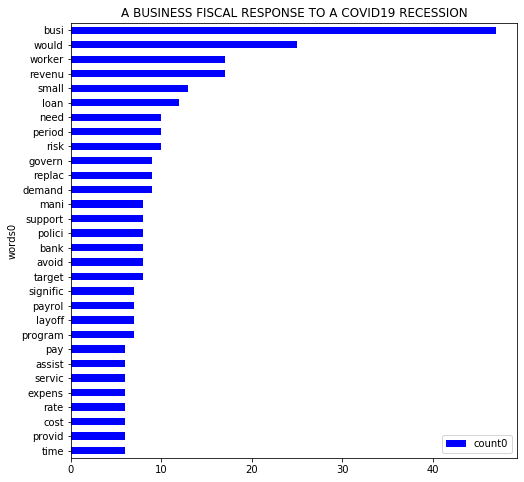

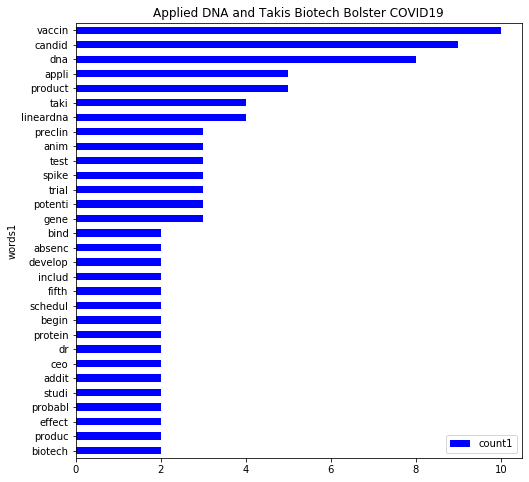

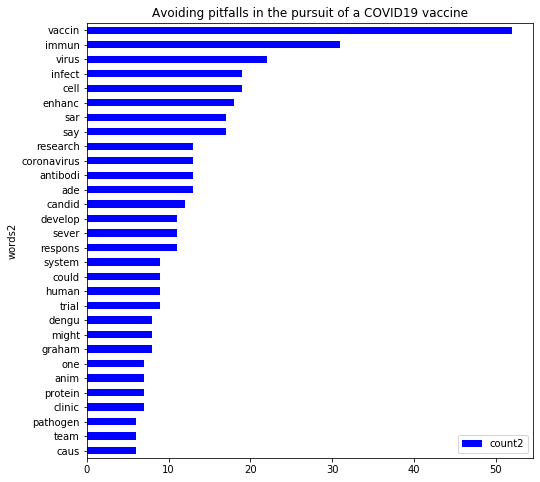

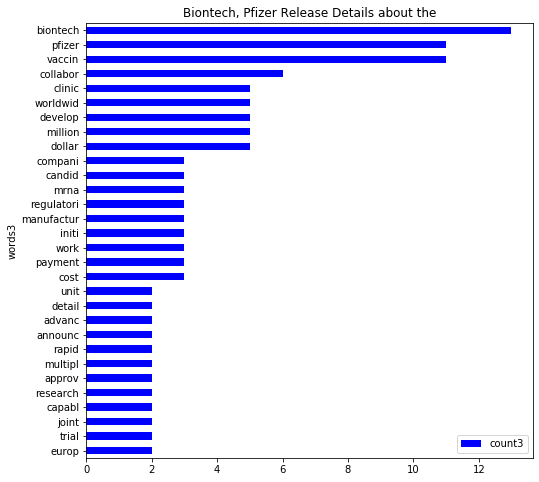

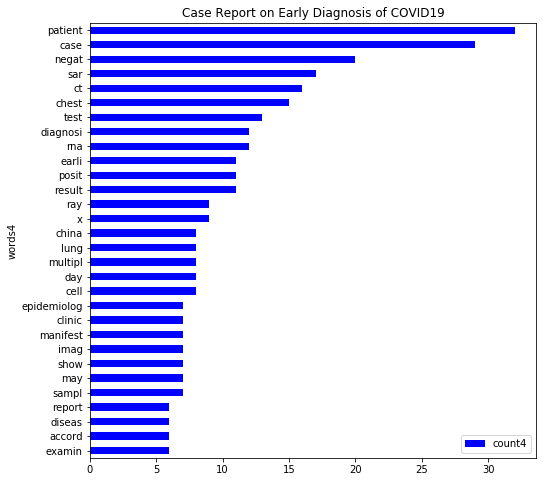

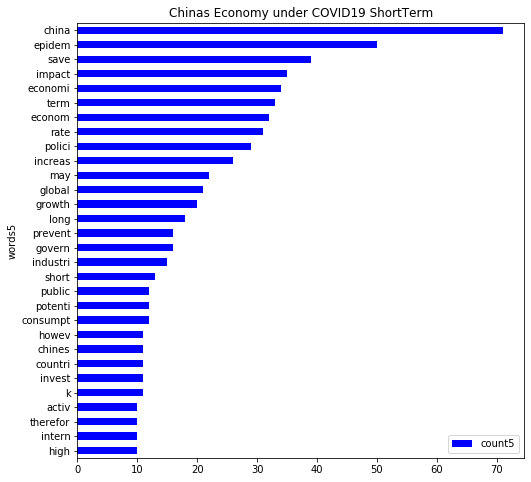

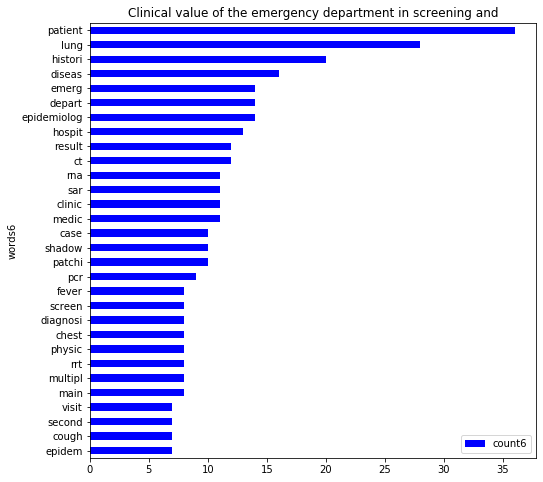

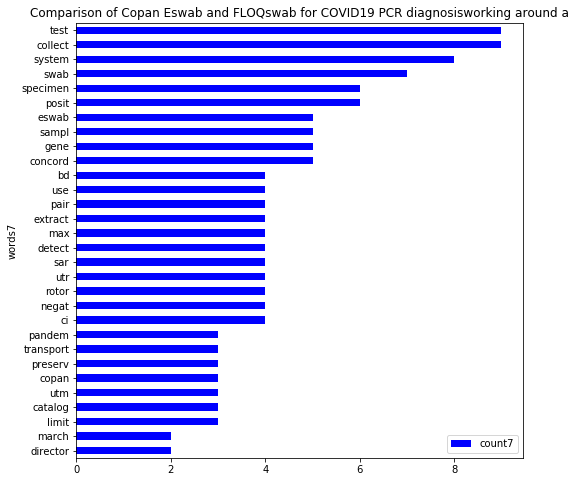

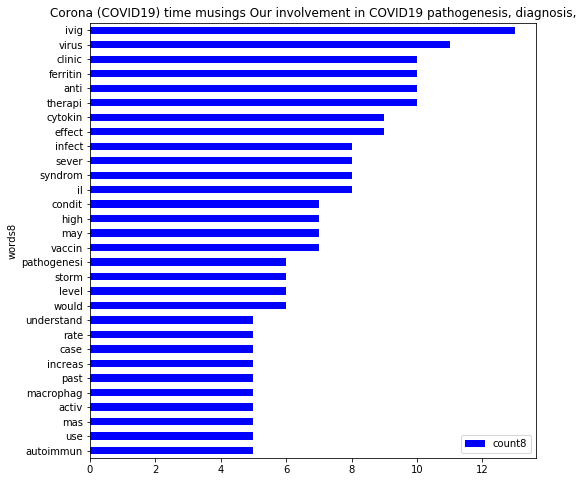

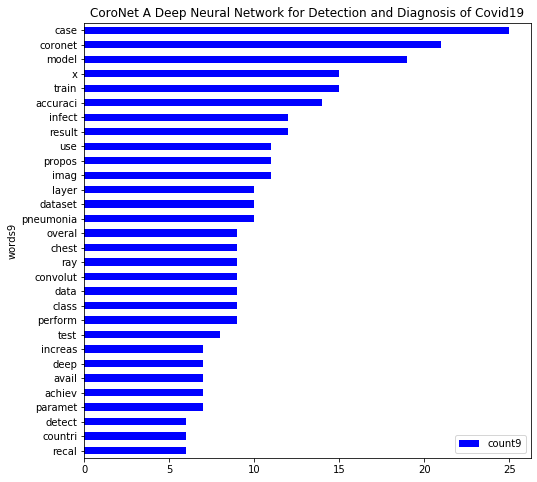

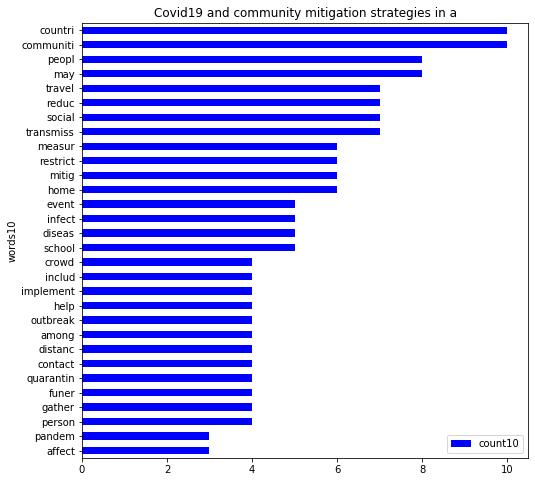

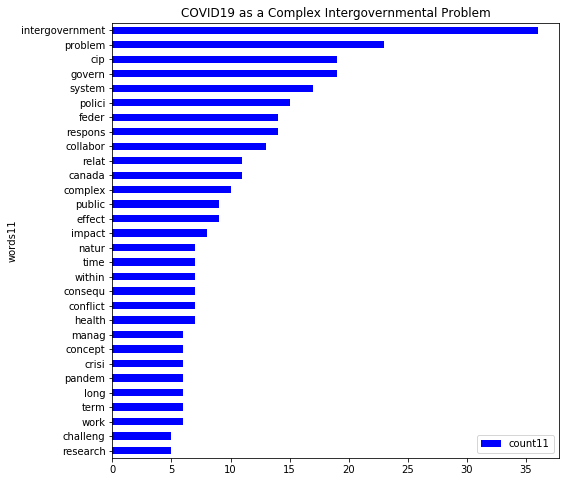

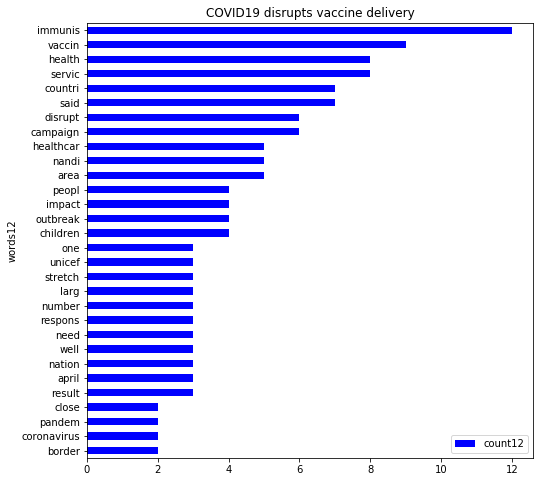

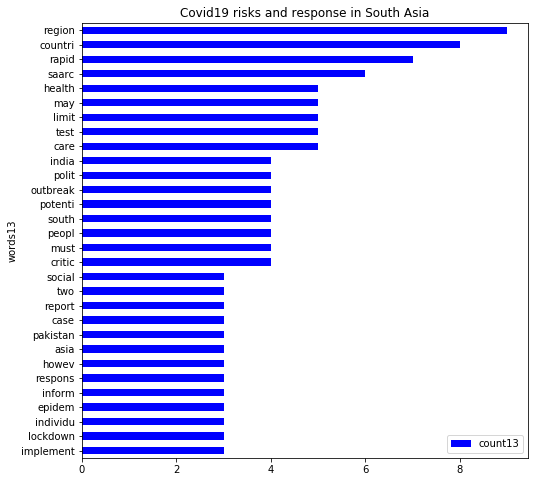

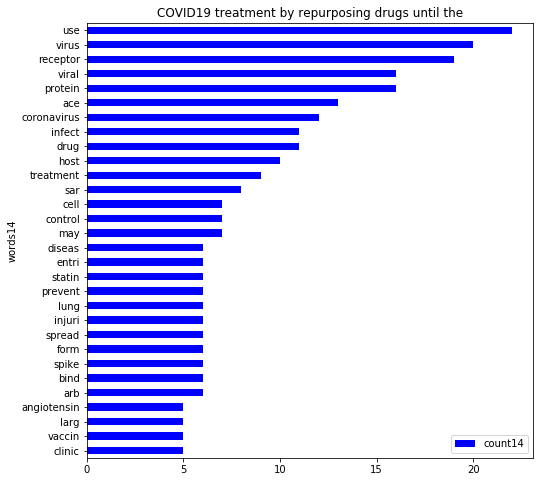

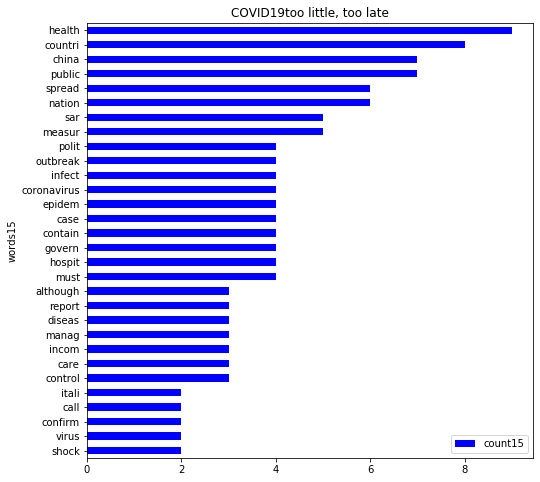

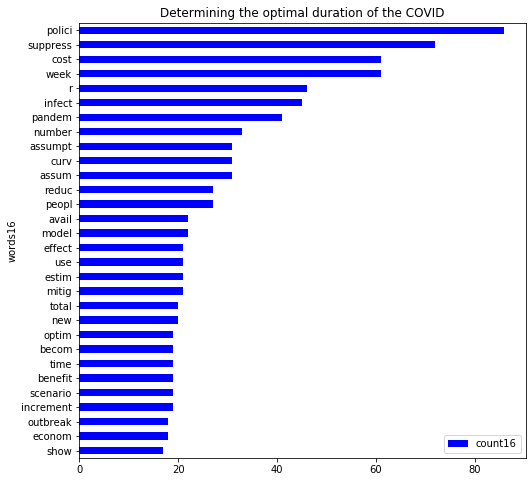

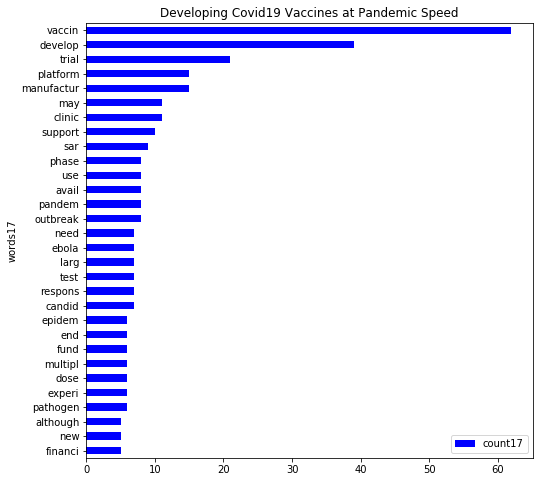

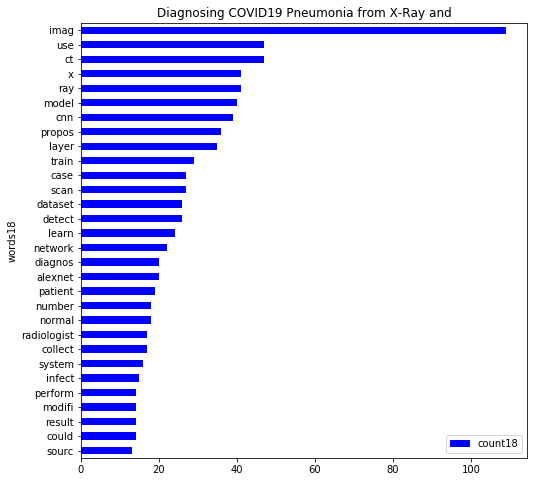

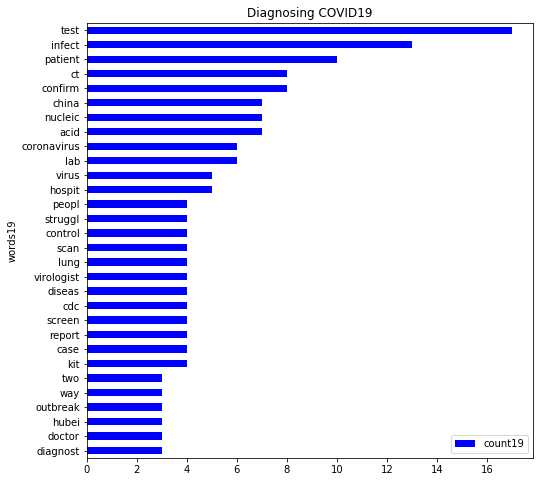

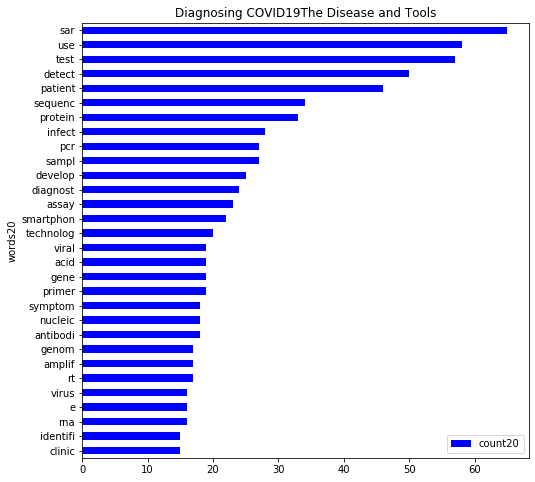

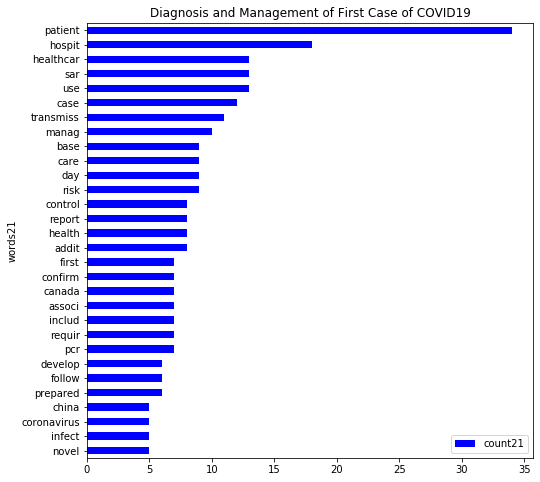

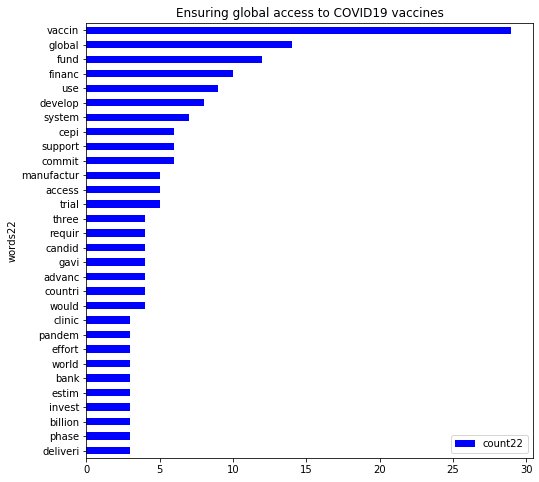

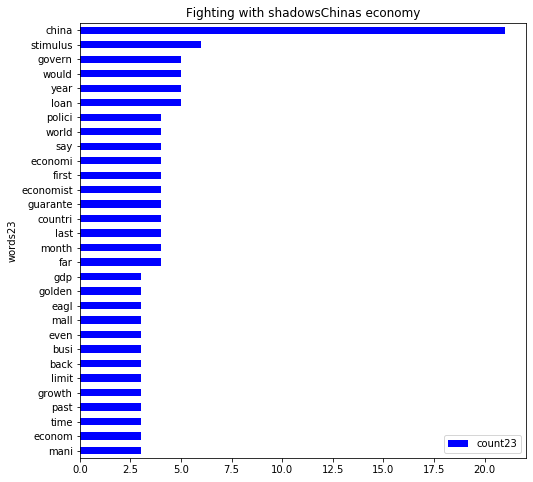

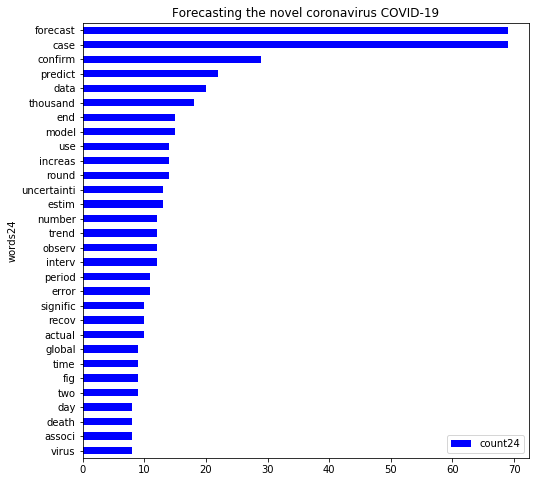

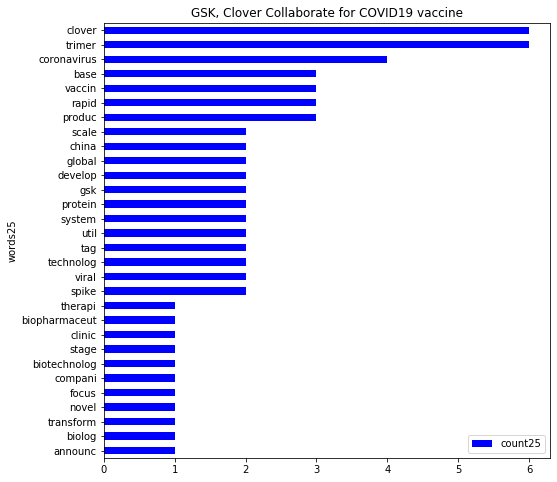

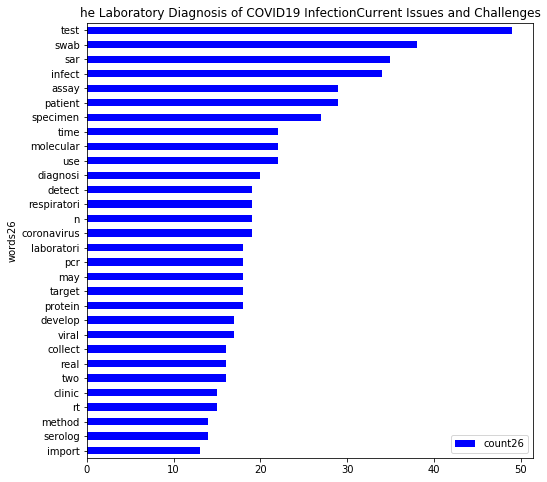

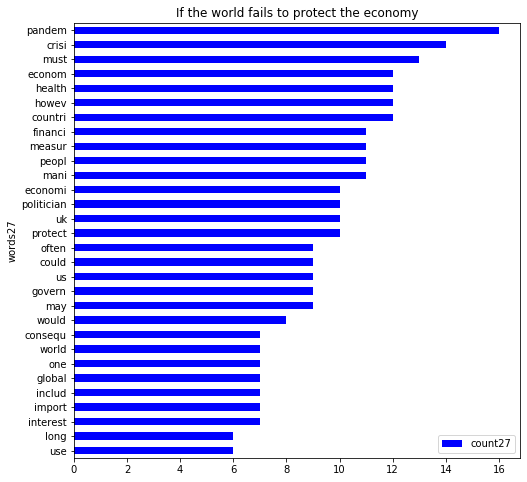

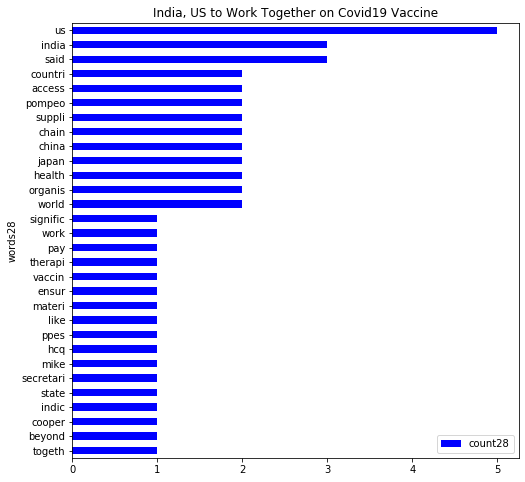

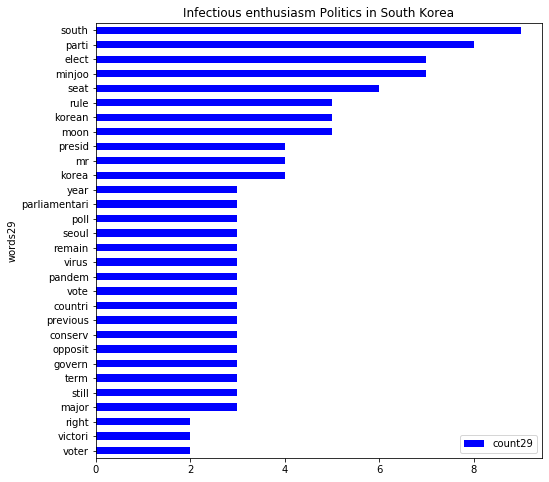

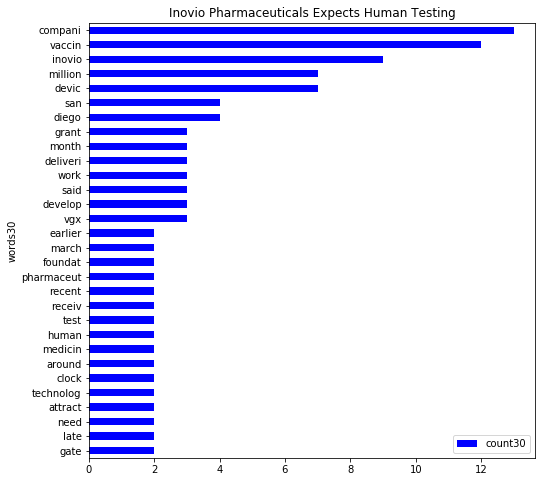

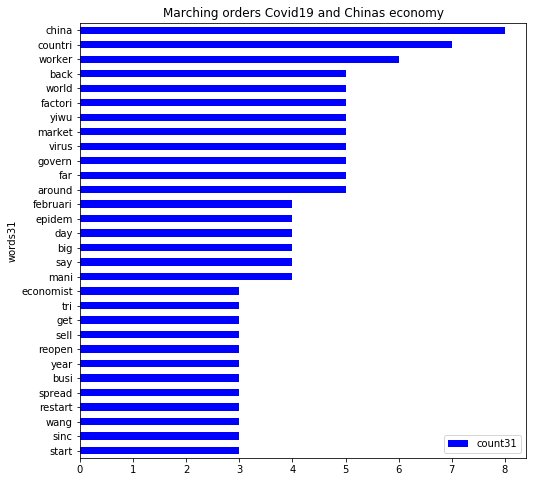

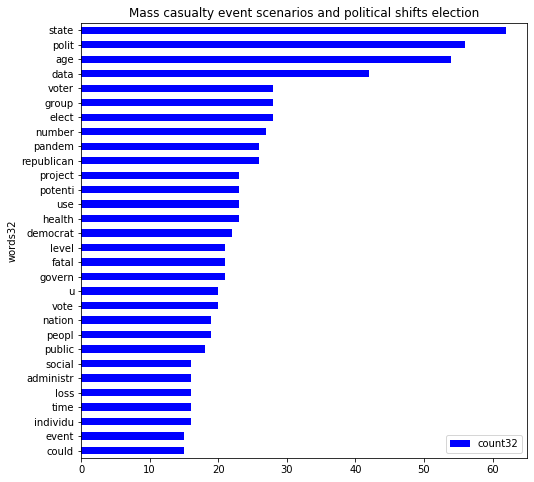

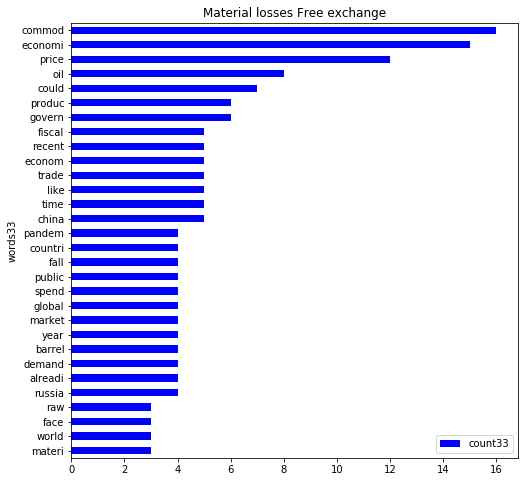

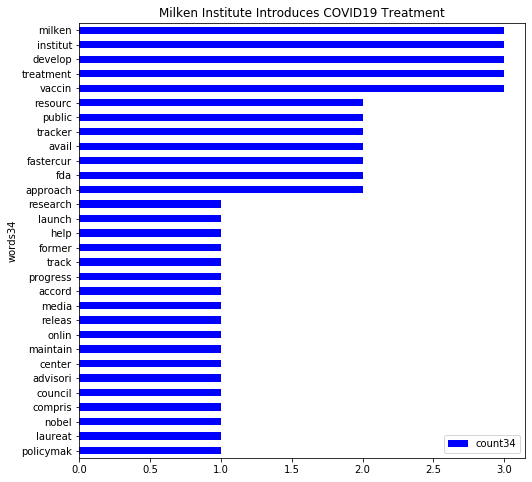

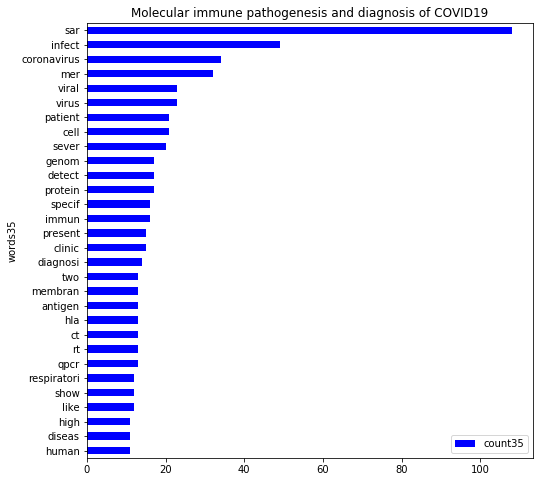

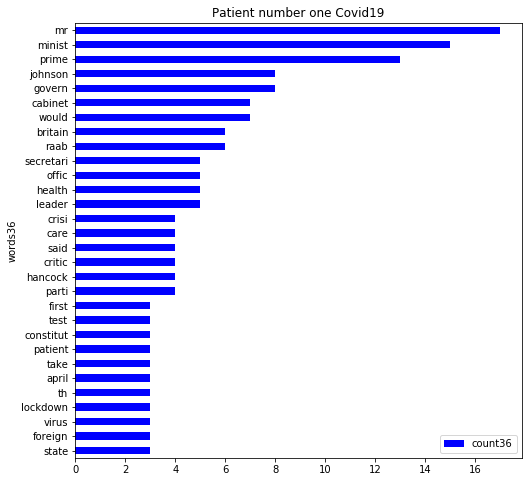

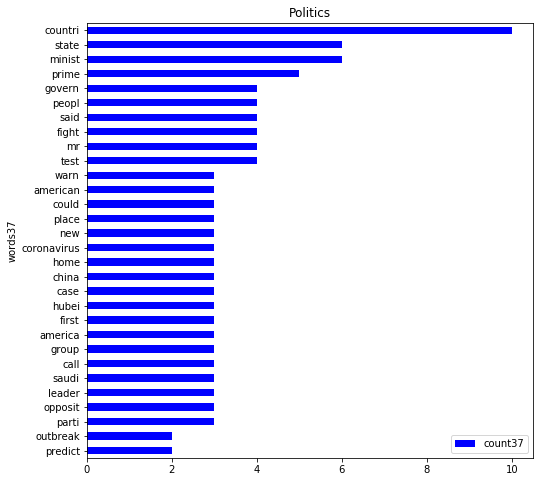

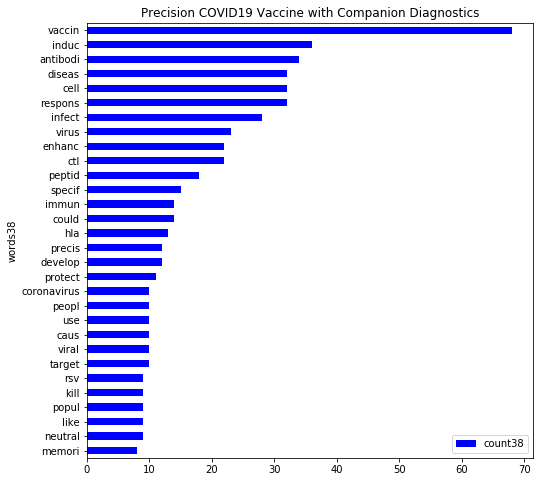

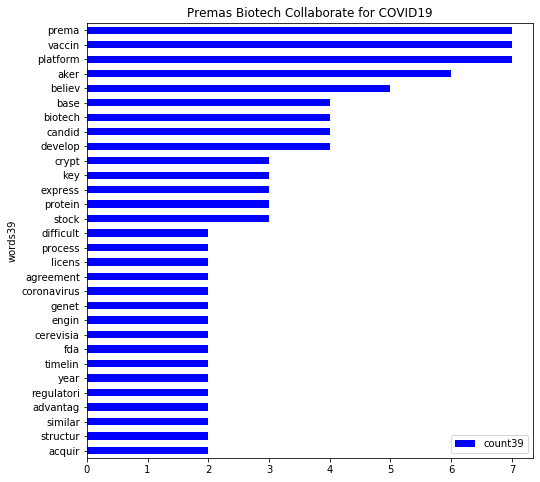

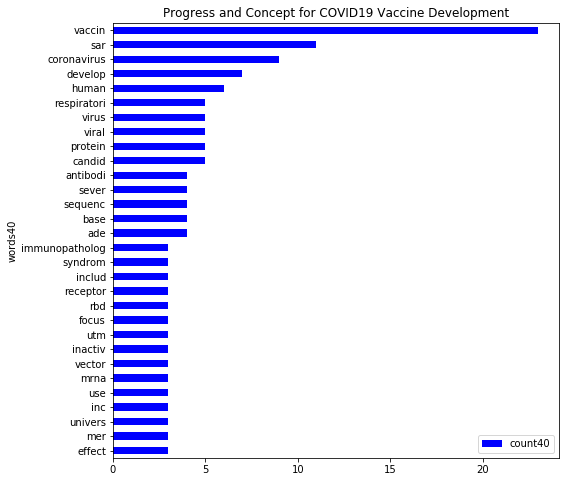

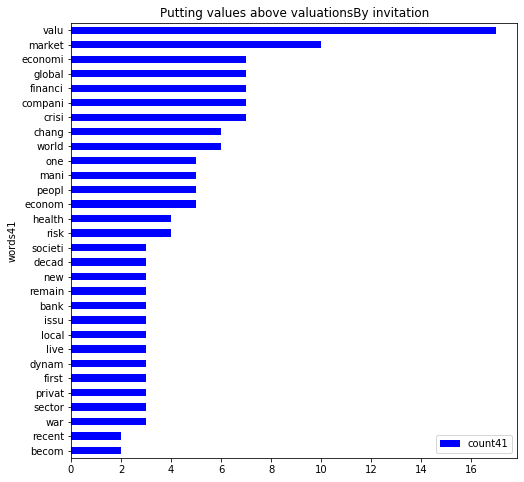

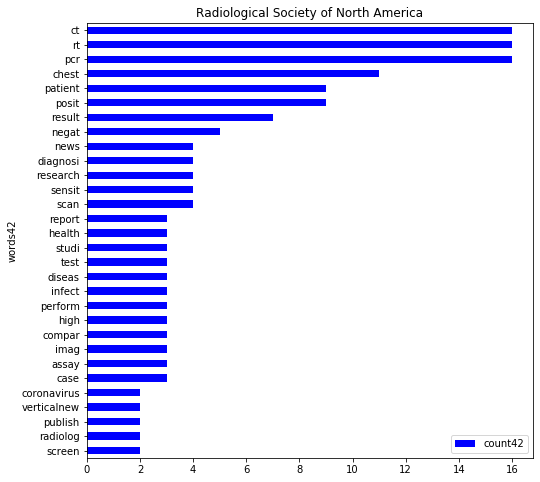

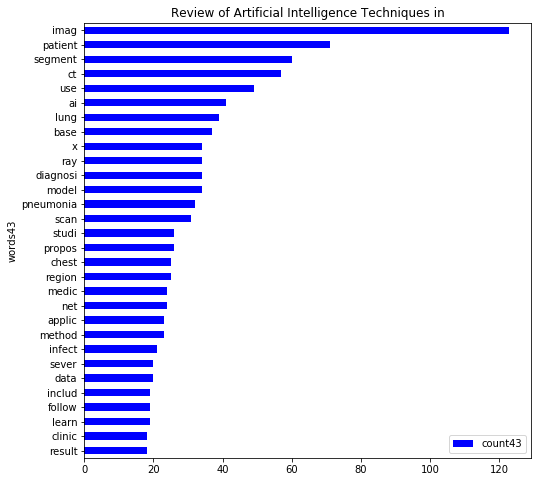

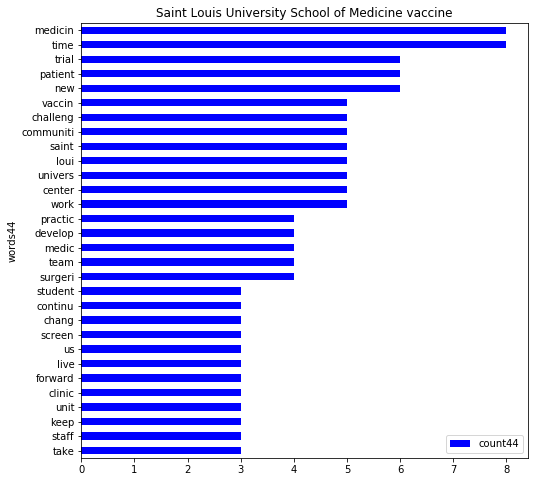

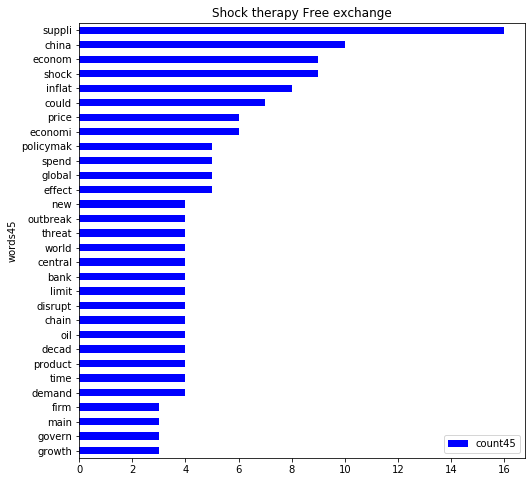

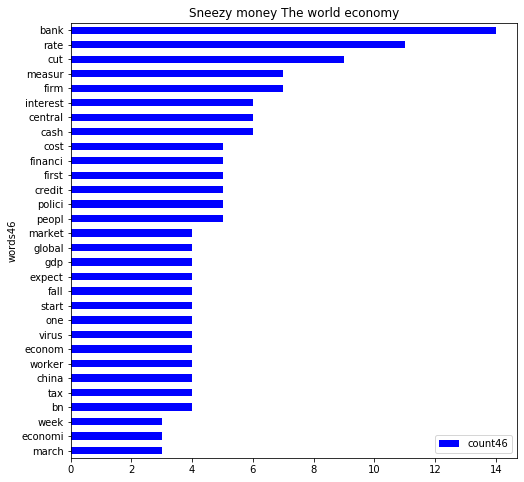

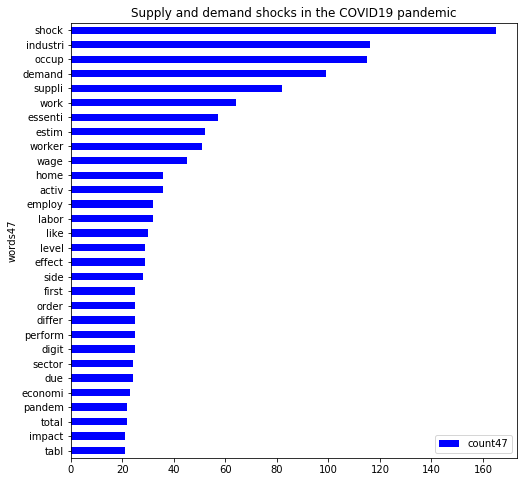

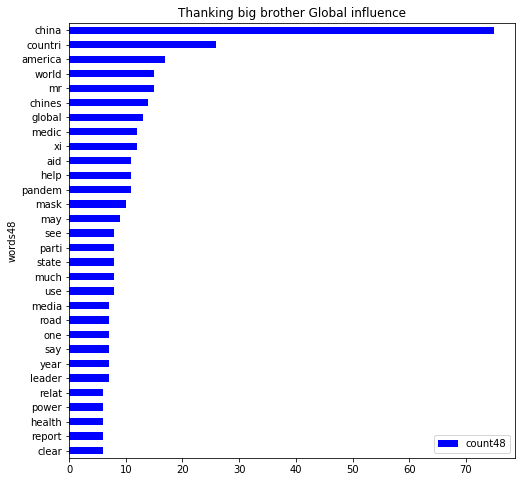

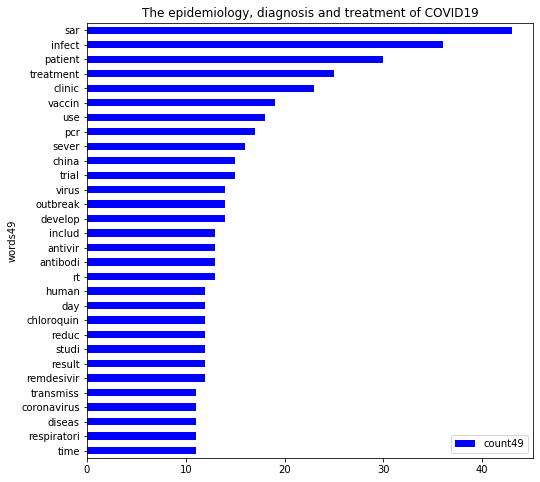

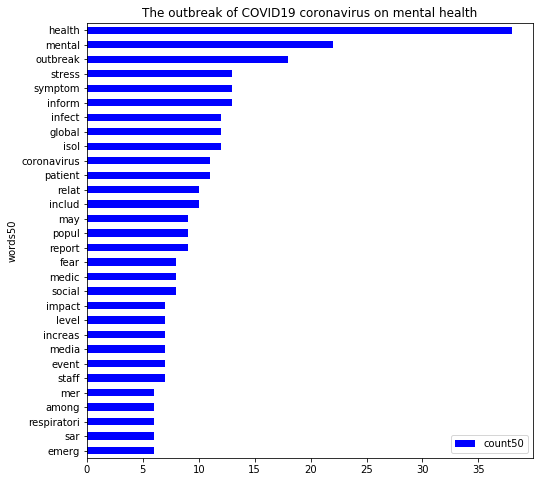

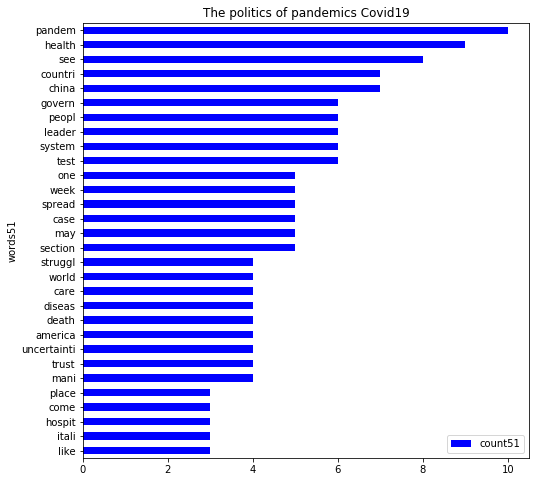

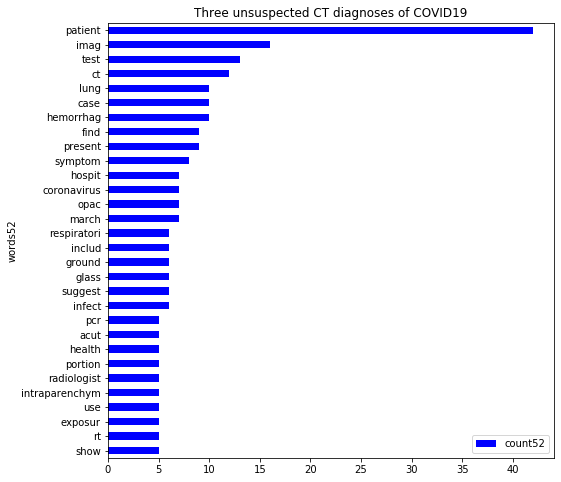

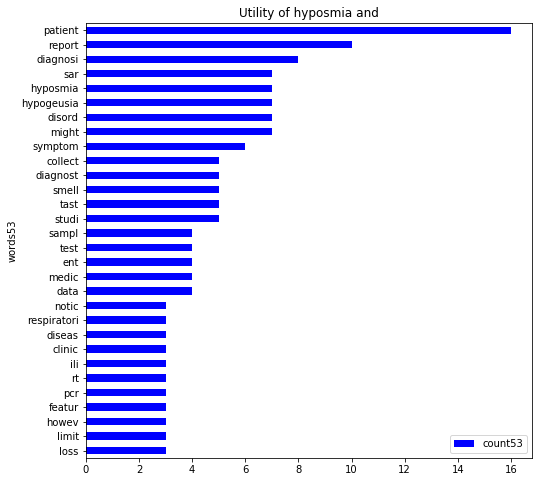

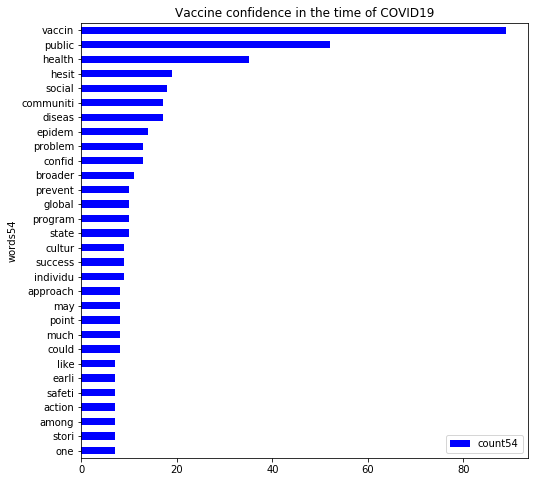

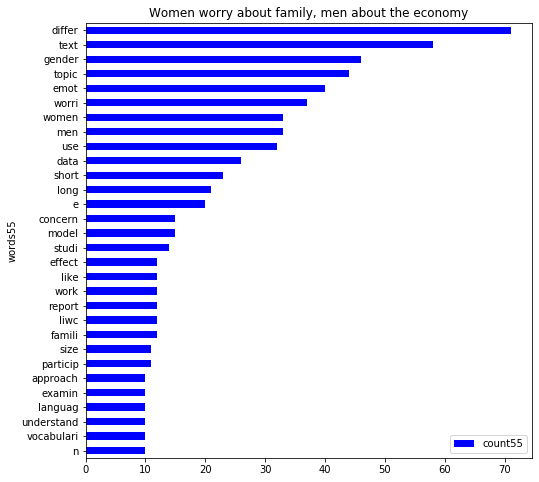

In [10]:
## use bar plot to display the result
colnames= words_count_df.columns
## read the file name to set as the plot title
import os
file_name = []
for name in os.listdir("...\\cov_txt\\"):
    file_name.append(name)

def barplot(words_count_df):
    s = 0
    for i, j in zip(range(0,len(colnames),2),range(1,len(colnames),2)):
        fig = plt.figure(figsize=(8,8))             

    # Divide the figure into a 2x1 grid, and give me the first section
        ax = fig.add_subplot(111)   

    # Plot horizontal bar graph
        words_count_df.sort_values(by=colnames[j]).plot.barh(x=colnames[i],y=colnames[j],ax=ax,color="blue")
        ax.set_title(file_name[s][:-4])
        plt.show()
        s+=1
## view the top30 word in each file            
barplot(words_count_df)

##### As we can see in the bar plot, different article have different frequency of word related to their topic

#### 1. Word Frequency - wordcloud

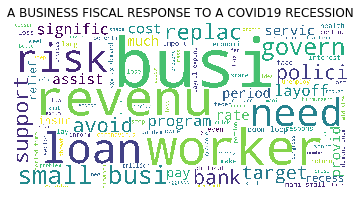

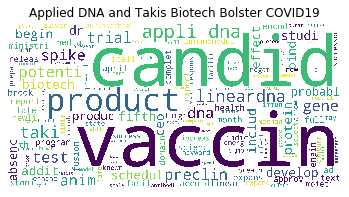

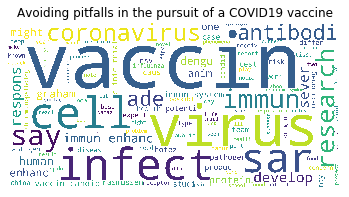

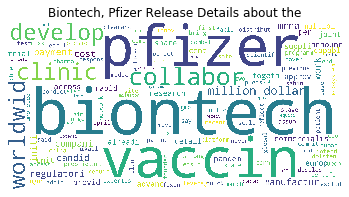

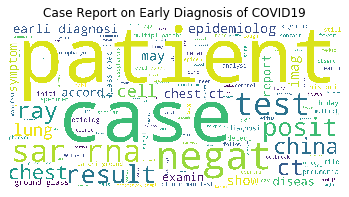

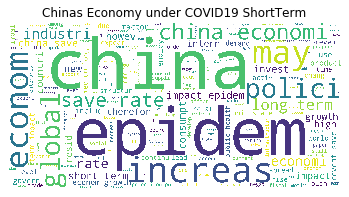

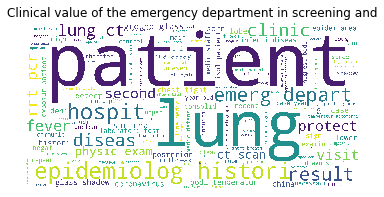

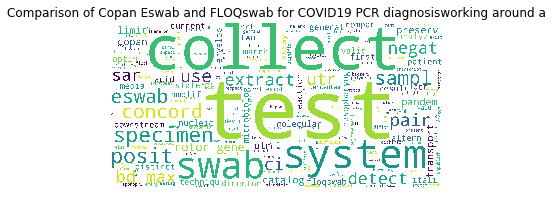

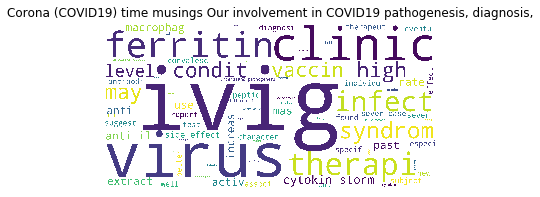

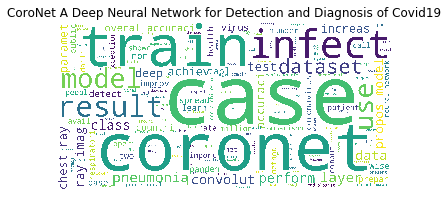

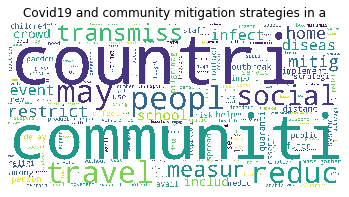

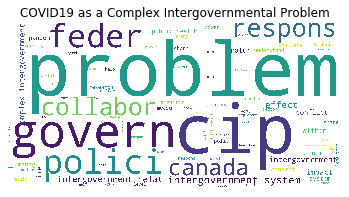

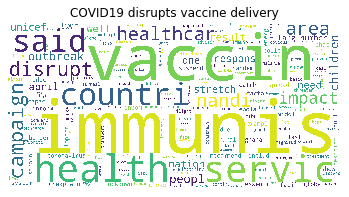

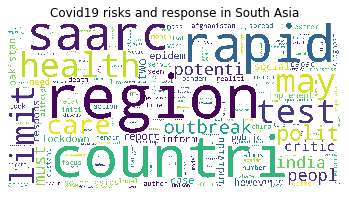

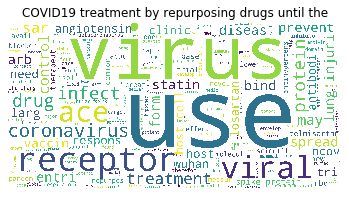

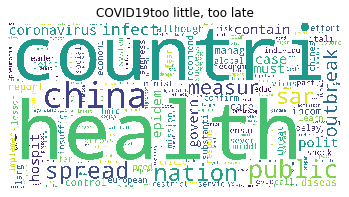

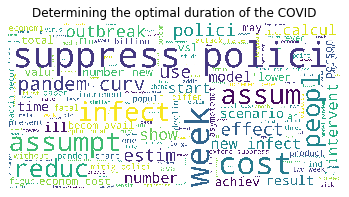

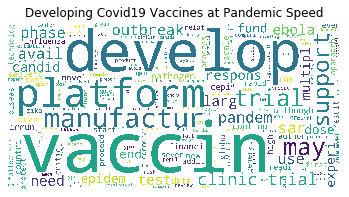

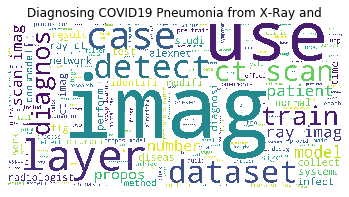

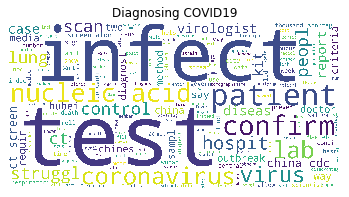

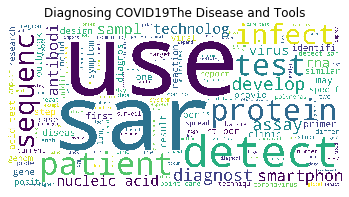

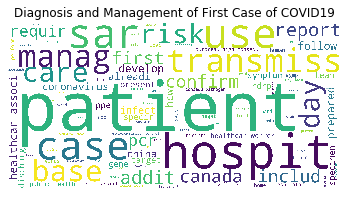

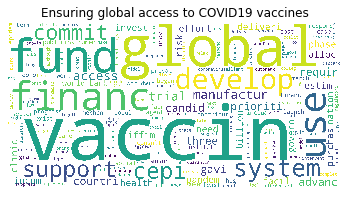

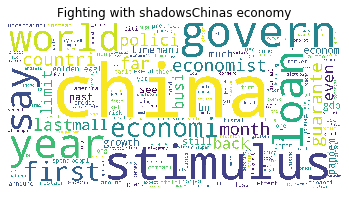

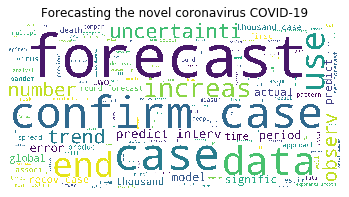

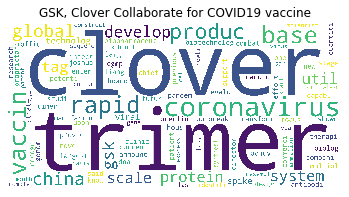

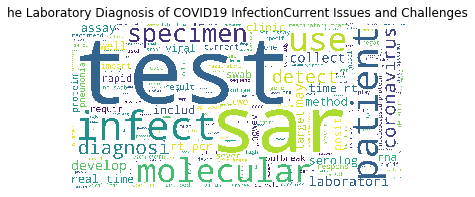

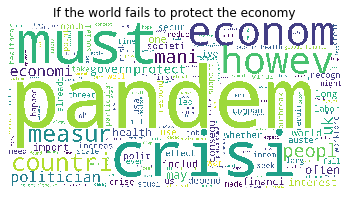

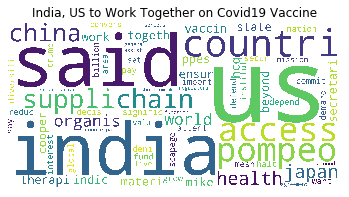

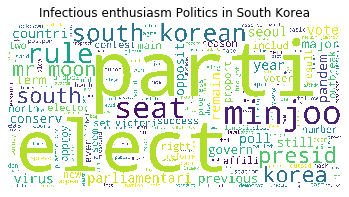

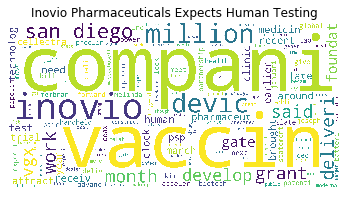

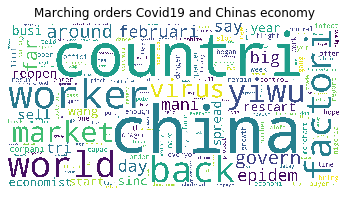

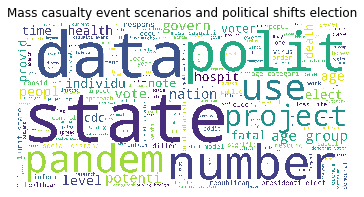

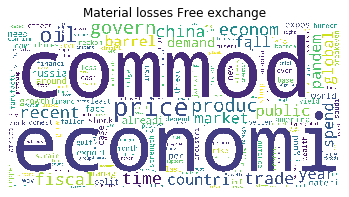

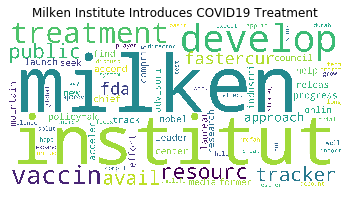

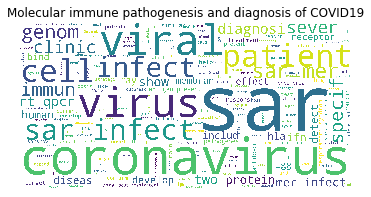

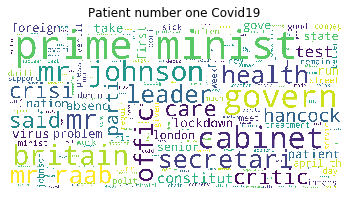

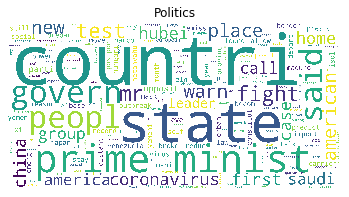

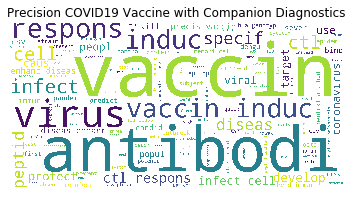

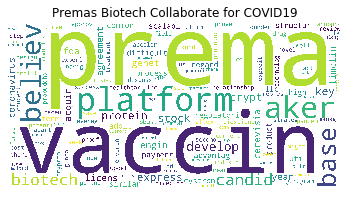

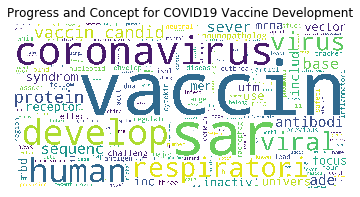

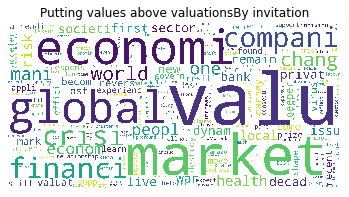

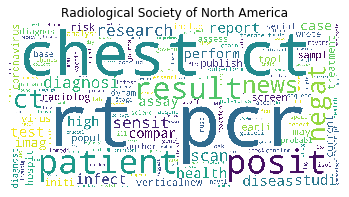

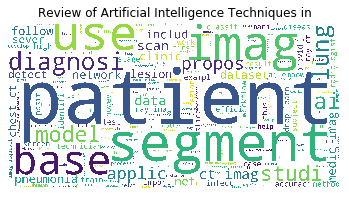

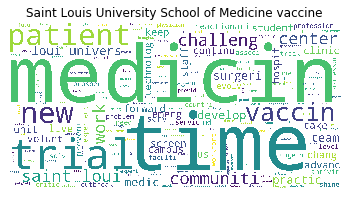

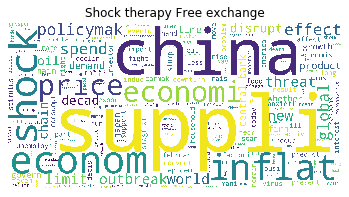

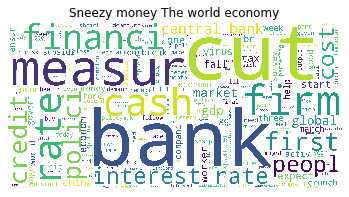

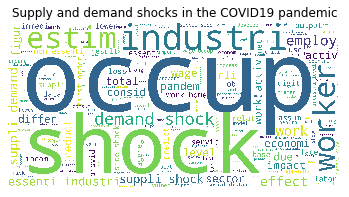

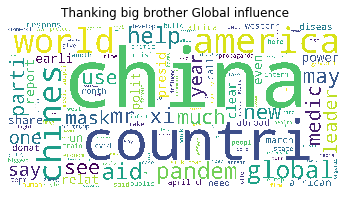

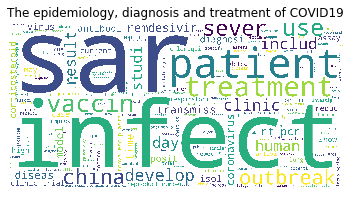

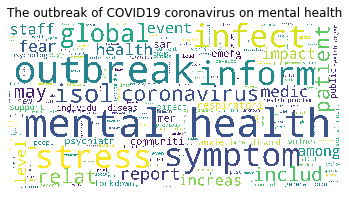

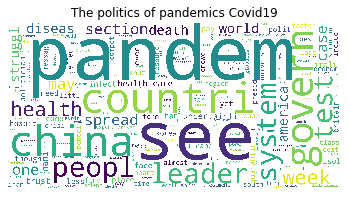

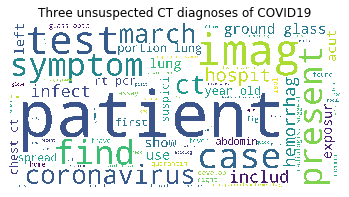

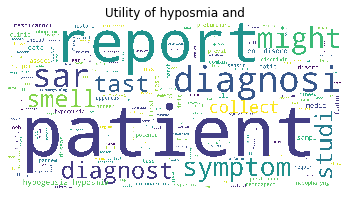

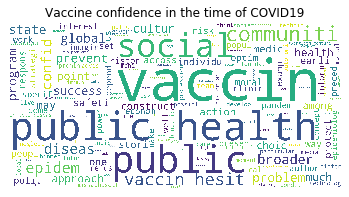

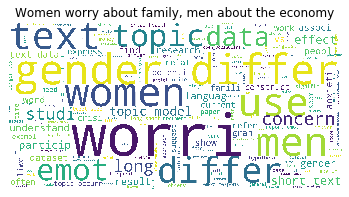

In [16]:
## see each file seperately
s = 0
for file in cov_stem:
    wordcloud = WordCloud(scale = 32, background_color="white", margin=2).generate(file)
    plt.imshow(wordcloud)
    plt.title(file_name[s][:-4])
    plt.axis("off")
    plt.show()
    s+=1

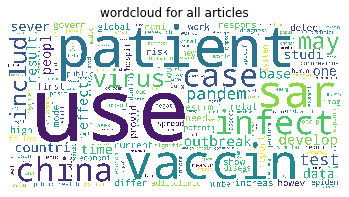

In [17]:
## see all document together
join = ' '
join = join.join(cov_stem)
wordcloud = WordCloud(scale = 32, background_color="white", margin=2).generate(join)
plt.imshow(wordcloud)
plt.title("wordcloud for all articles")
plt.axis("off")
plt.show()

**Explanation:**

* Wordcloud are more easy to observe than bar plot, as more frequency word is more bigger, we can easily find that some wordcloud are similar while some are different.
* Wordcloud is more straigtforward the bar plot, the most frequent words accociate with the title of the article.

#### 2. TF-IDF analysis


In [7]:
## transform into term document matrix
vectorizer= CountVectorizer()
## calculate tfidf
transformer= TfidfTransformer()
## transform into term document matrix and calculate tfidf
tfidf_matrix=transformer.fit_transform(vectorizer.fit_transform(cov_stem))
## get the word and tfidf
terms=vectorizer.get_feature_names()
weight=tfidf_matrix.toarray()
tfidf_matrix.shape
## check the shape to see if it is correct
weight.shape
## correct, 56 file and 5841 word

(56, 5840)

In [8]:
## the tfidf matrix
print(terms)
print(weight)

['abandon', 'abbott', 'abdomen', 'abdomin', 'aberr', 'abid', 'abil', 'abiy', 'abject', 'abl', 'abnorm', 'abroad', 'abrupt', 'absenc', 'absent', 'absente', 'absolut', 'absorb', 'absorpt', 'abstract', 'absurd', 'academ', 'academi', 'acc', 'accel', 'acceler', 'accept', 'access', 'accessori', 'accid', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accumul', 'accur', 'accuraci', 'accus', 'ace', 'ach', 'achiev', 'acid', 'acknowledg', 'acquir', 'acquisit', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'acut', 'ad', 'adam', 'adamsprassl', 'adapt', 'add', 'addit', 'address', 'ade', 'adenosin', 'adenovirus', 'adequ', 'adher', 'adjust', 'adjuv', 'administ', 'administr', 'admir', 'admiss', 'admit', 'admonish', 'adolesc', 'adopt', 'adrian', 'adsorb', 'adult', 'advanc', 'advantag', 'advers', 'advic', 'advis', 'advisor', 'advisori', 'advoc', 'aerosol', 'aesthet', 'af', 'affair', 'affect', 'affili', 'affin', 'affini', 'affix', 'affluent', 'afford', 'afghanistan', 'aforement', 'a

In [19]:
## print the top 5 word in each file
df_tfidf = pd.DataFrame()
for i in range(len(weight)):
    arr = []
    tryy = []
    print ("-------The tf-idf of",i, "document------")
    for j in range(len(terms)):
        arr.append([terms[j],weight[i][j]])
        arr.sort(key = lambda s: s[1])
    print(arr[-6:-1][::-1])
    for s in range(5):
        tryy.append(arr[-6:-1][::-1][s][0])
    df_tfidf[i] = tryy

-------The tf-idf of 0 document------
[['revenu', 0.25455529056945586], ['would', 0.19064734201997707], ['loan', 0.17193902894014326], ['worker', 0.16425989890344267], ['payrol', 0.14721427799790693]]
-------The tf-idf of 1 document------
[['candid', 0.34309344955921495], ['taki', 0.2840681259575151], ['lineardna', 0.2840681259575151], ['vaccin', 0.2626976387585315], ['appli', 0.1803903330633163]]
-------The tf-idf of 2 document------
[['immun', 0.32465267757711247], ['ade', 0.24301073950917998], ['cell', 0.2102507516685405], ['enhanc', 0.19918492263335416], ['say', 0.16494202036890104]]
-------The tf-idf of 3 document------
[['pfizer', 0.5174607402161866], ['dollar', 0.19772934777561327], ['collabor', 0.19229912181627917], ['vaccin', 0.19141283682825364], ['worldwid', 0.13832482709289085]]
-------The tf-idf of 4 document------
[['case', 0.26175848948618385], ['ct', 0.25167361733723054], ['chest', 0.24321746745017164], ['negat', 0.23358316679450983], ['rna', 0.18875521300292292]]
-----

In [55]:
## show the dataframe for better view
df_tfidf.T

,0,1,2,3,4
0,revenu,would,loan,worker,payrol
1,candid,taki,lineardna,vaccin,appli
2,immun,ade,cell,enhanc,say
3,pfizer,dollar,collabor,vaccin,worldwid
4,case,ct,chest,negat,rna
5,china,impact,epidem,economi,polici
6,patient,histori,shadow,depart,patchi
7,concord,collect,swab,specimen,utr
8,ferritin,therapi,anti,il,cytokin
9,accuraci,train,case,layer,dataset


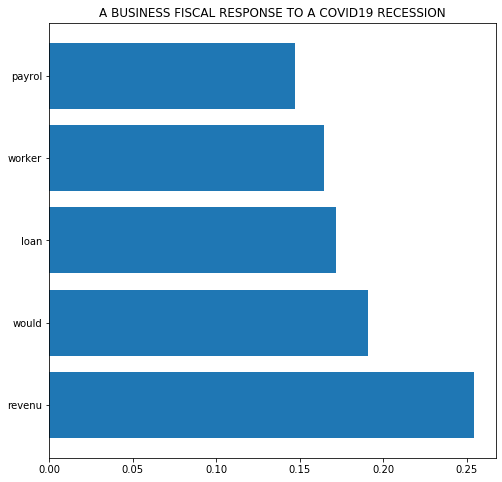

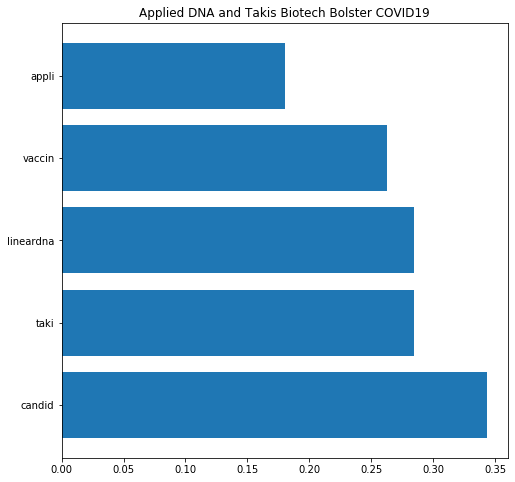

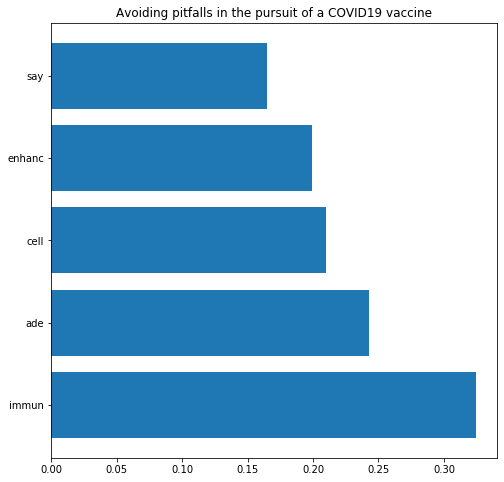

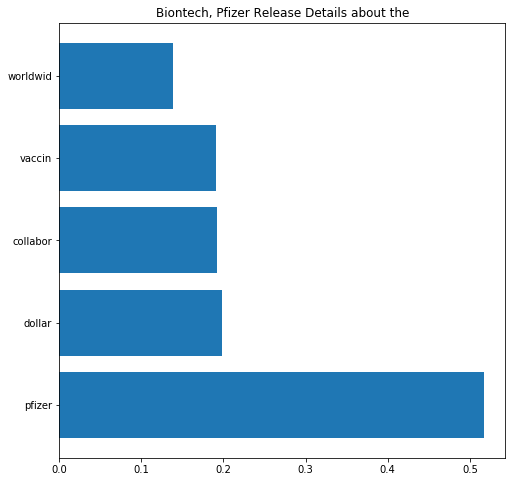

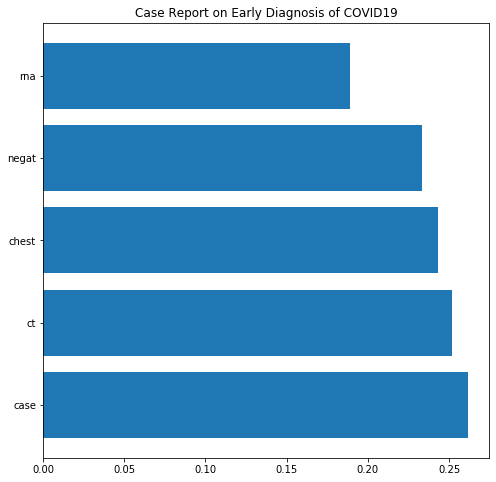

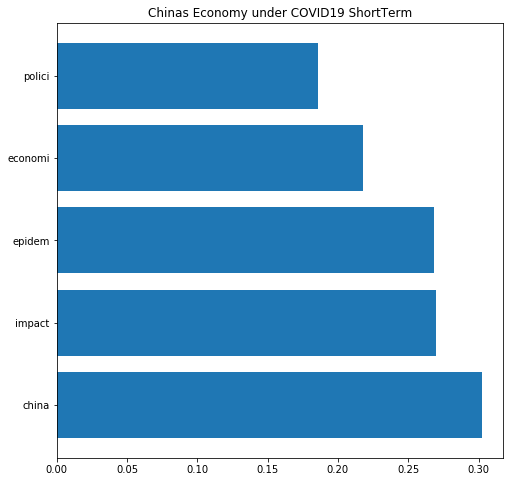

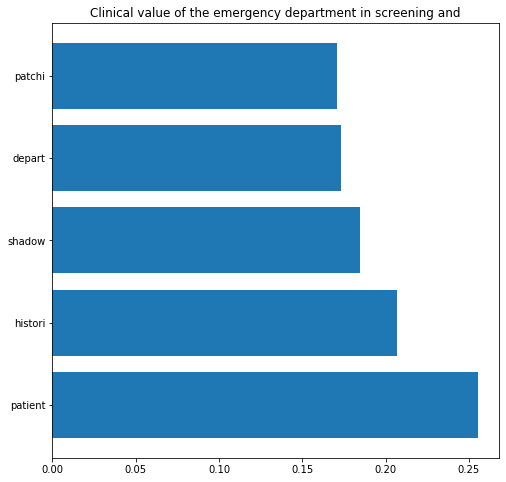

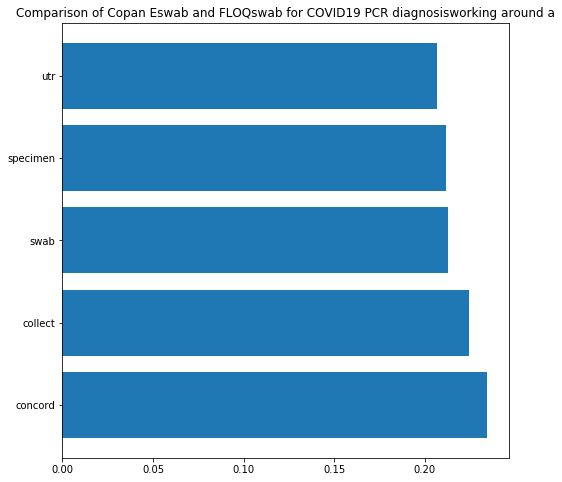

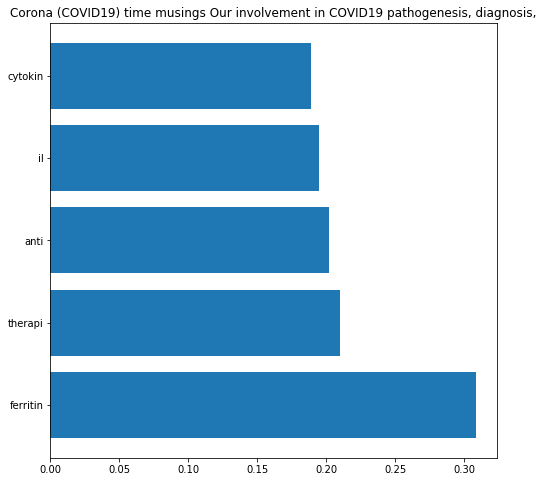

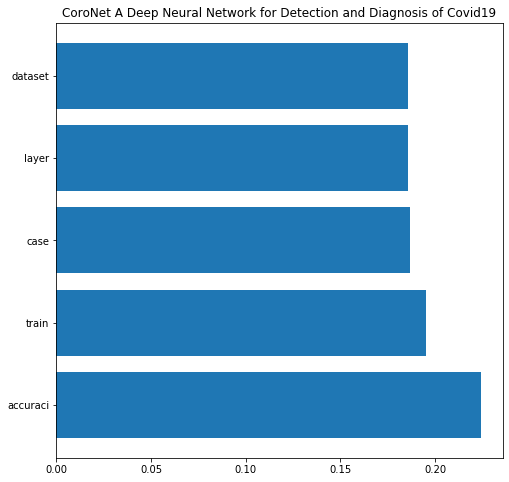

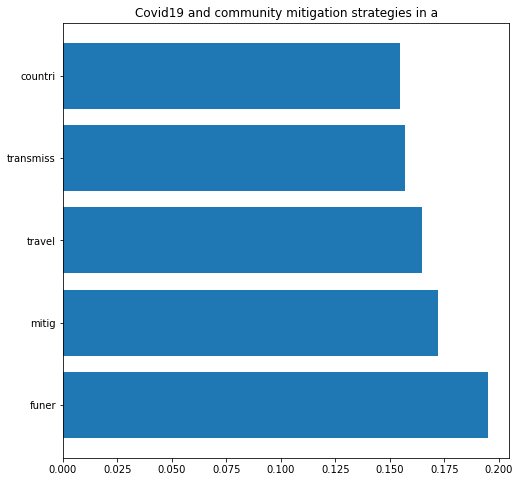

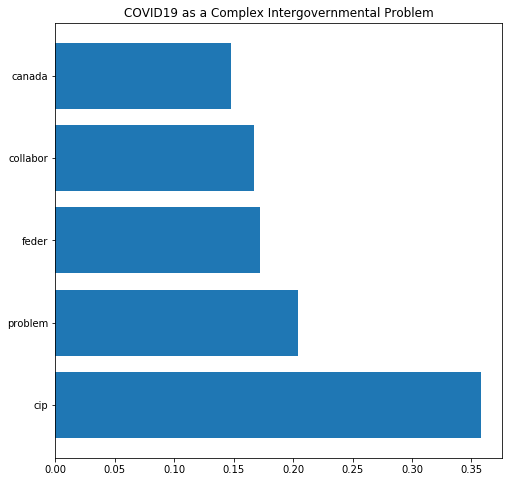

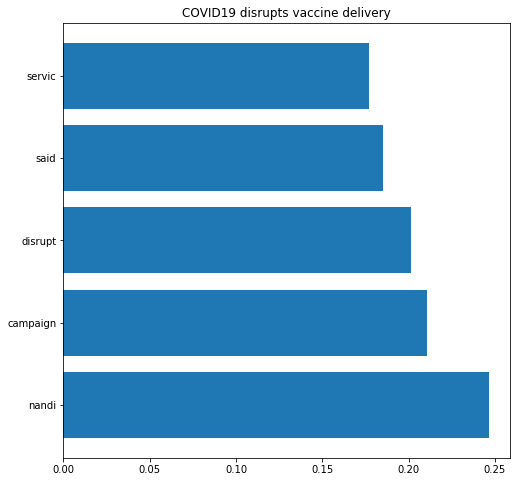

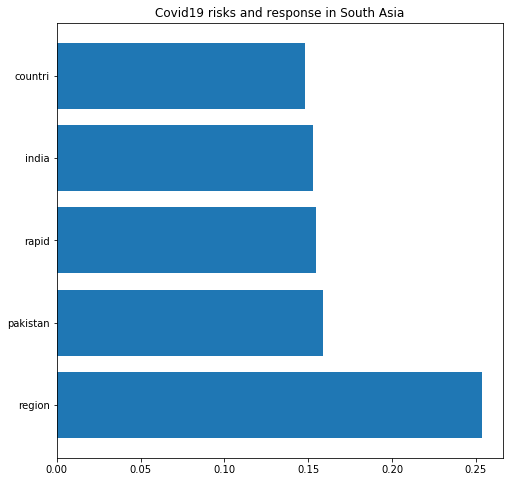

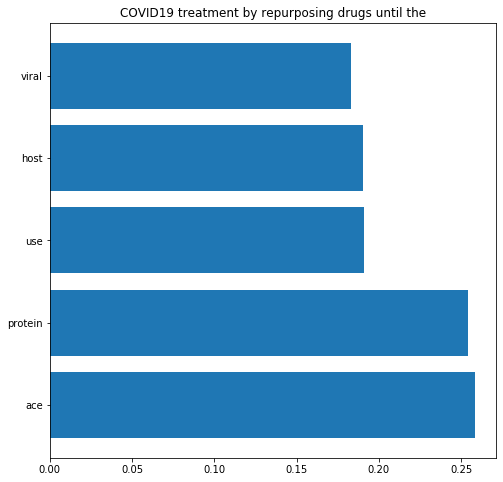

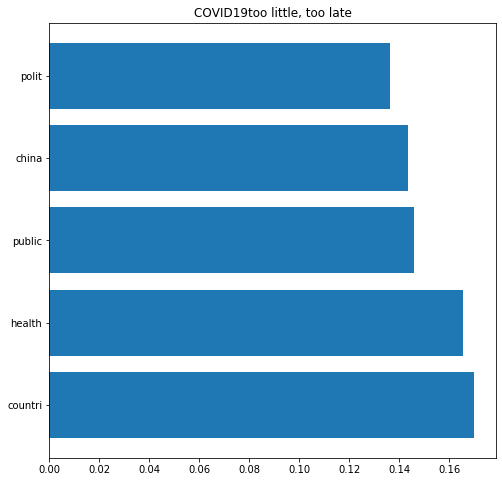

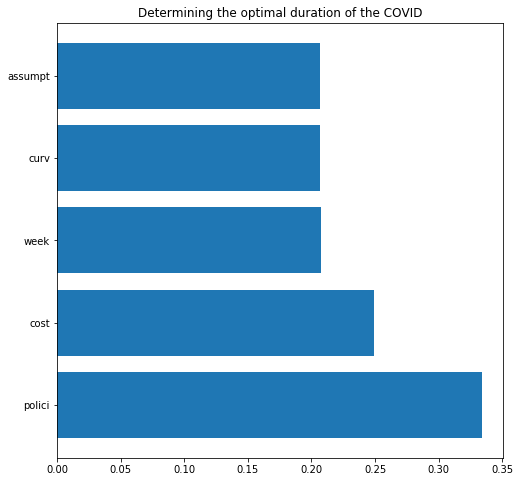

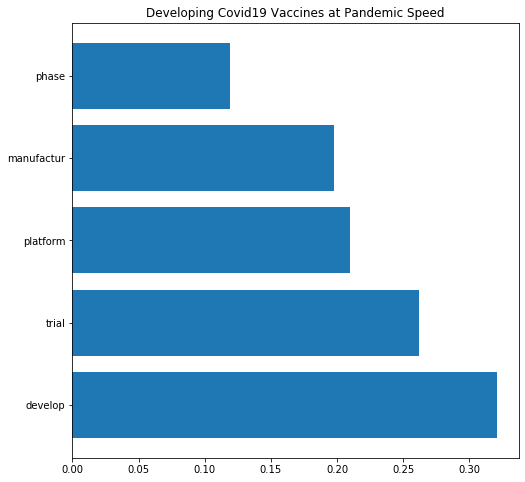

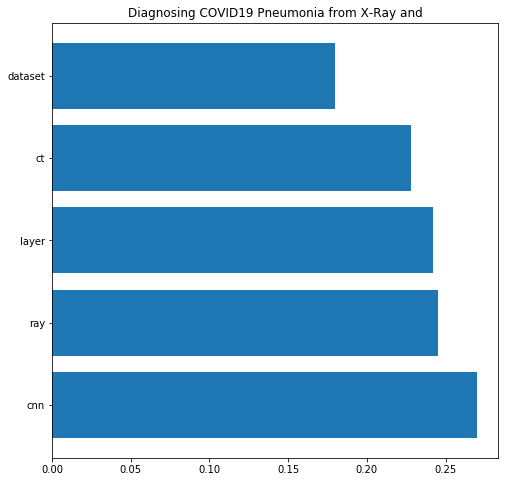

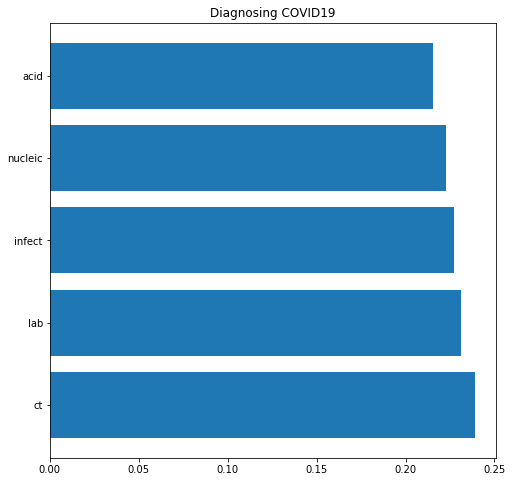

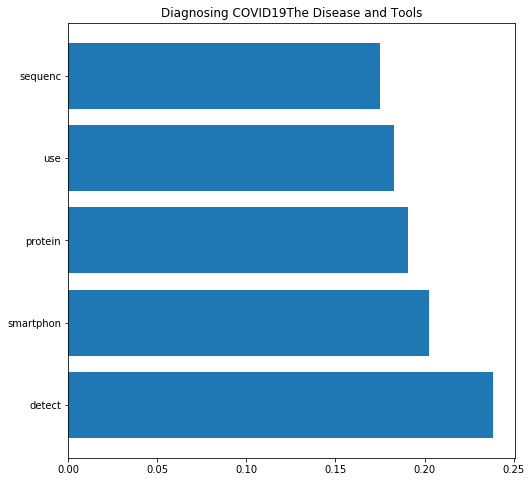

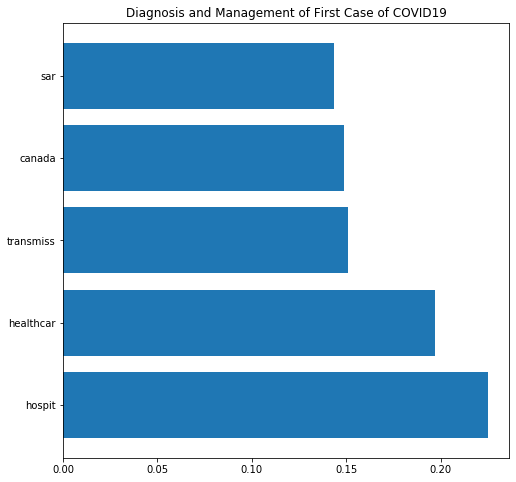

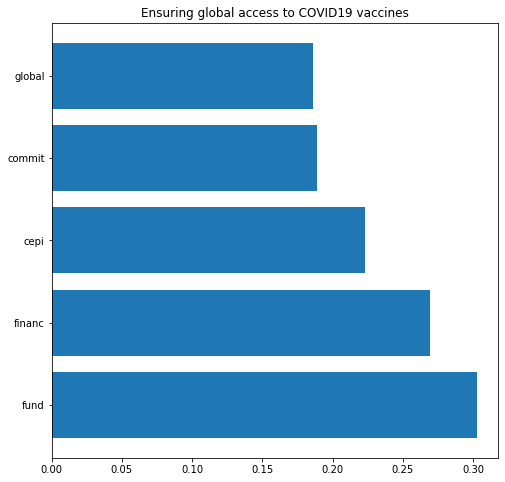

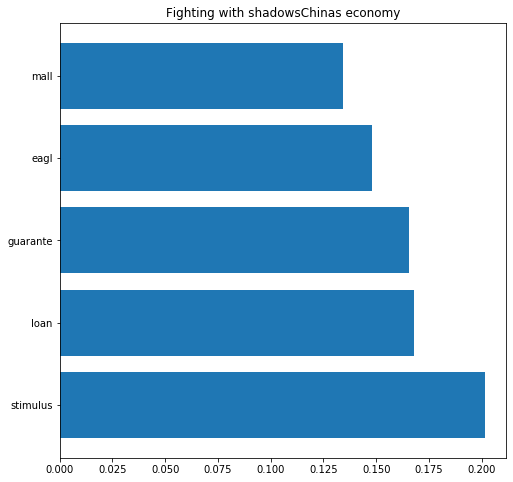

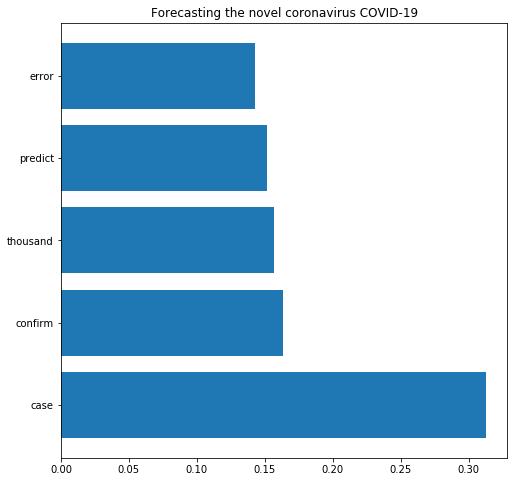

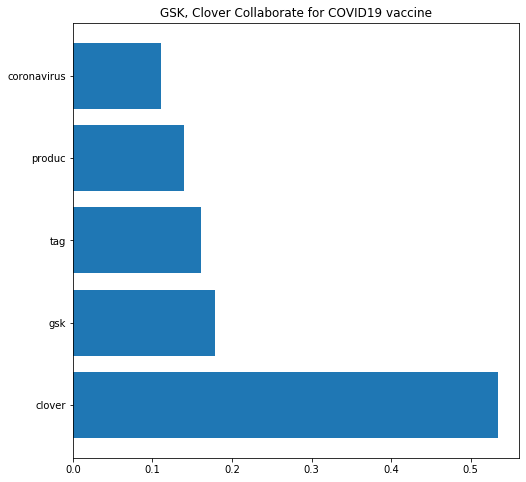

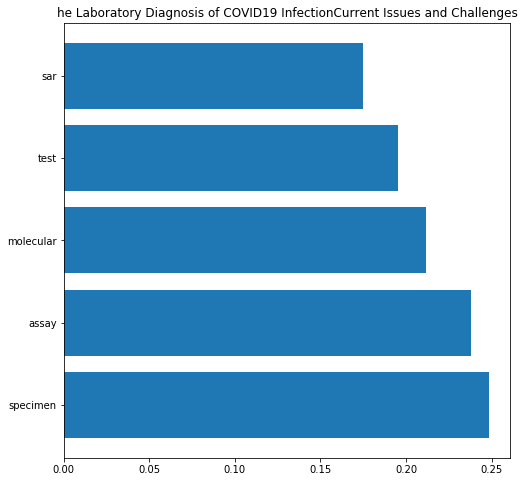

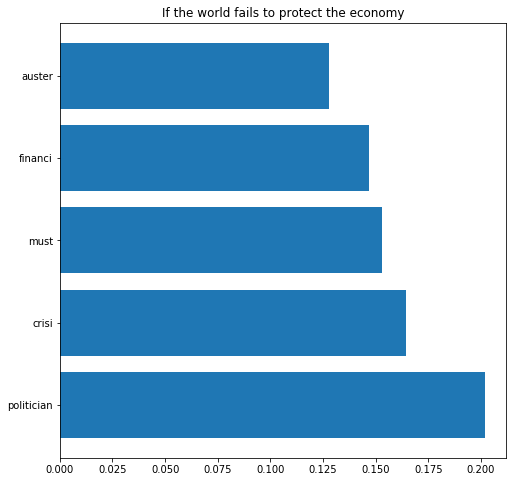

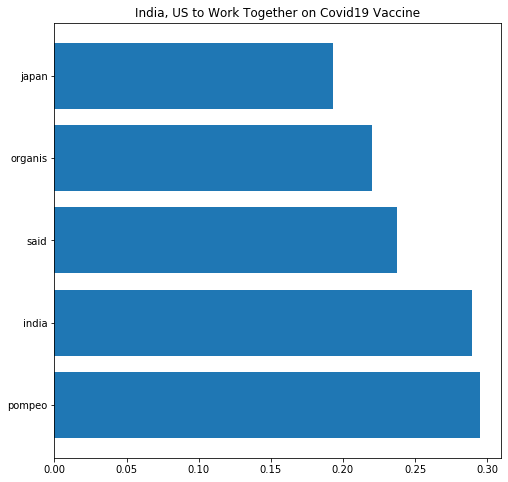

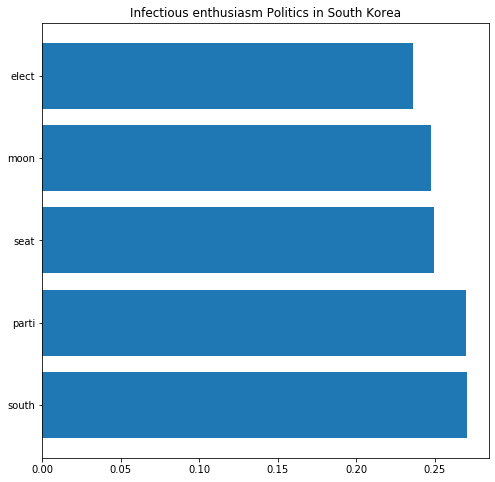

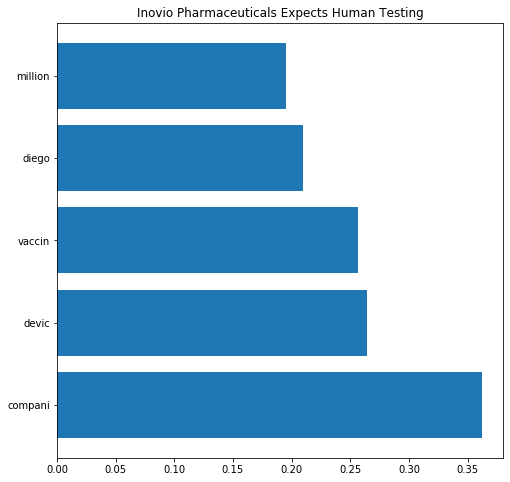

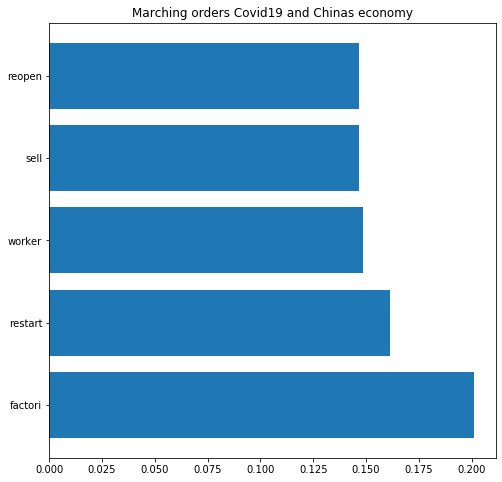

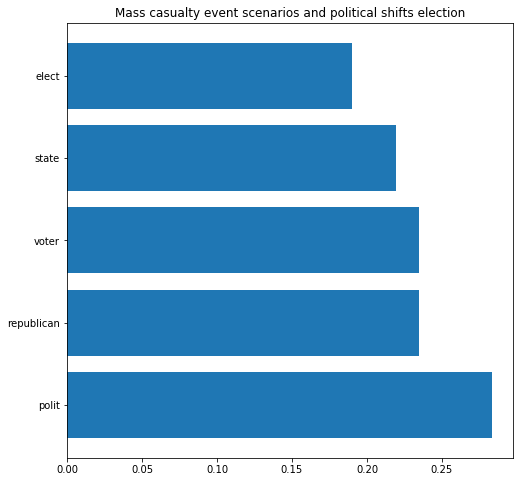

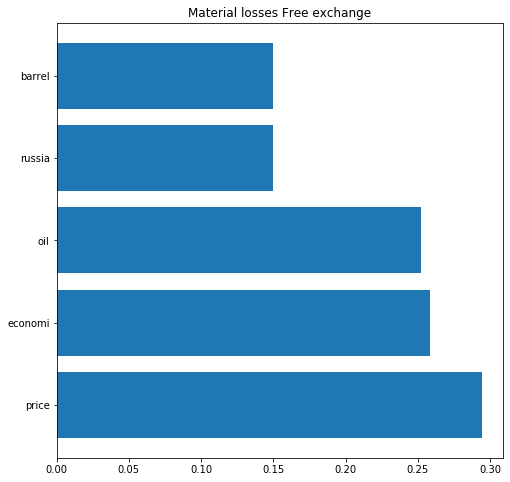

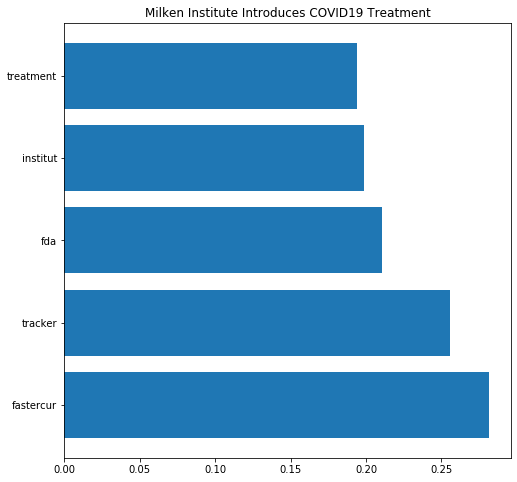

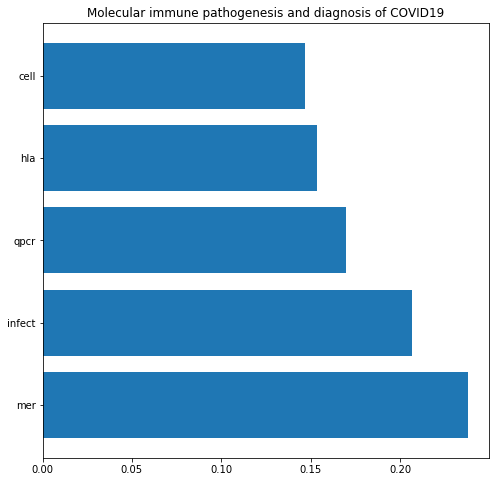

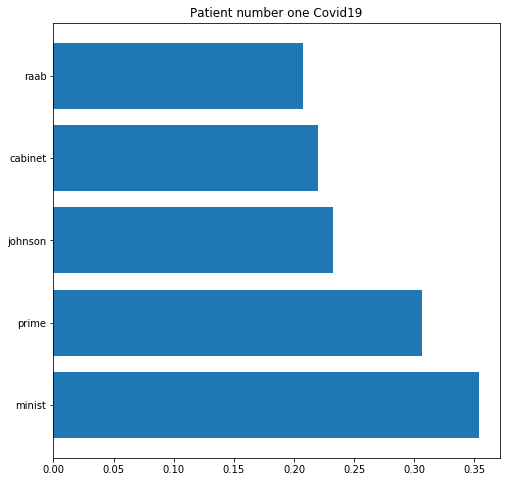

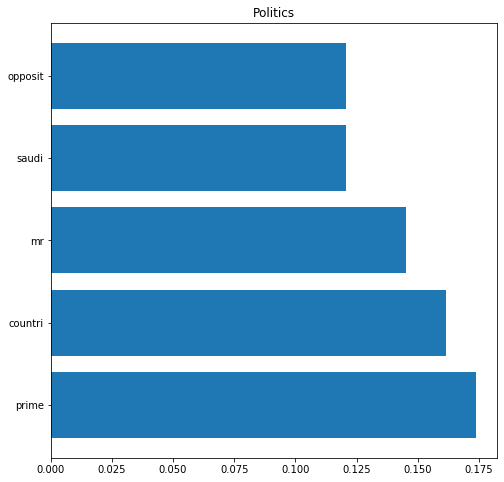

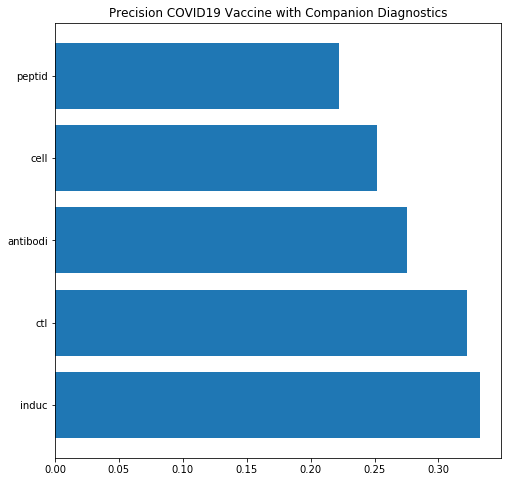

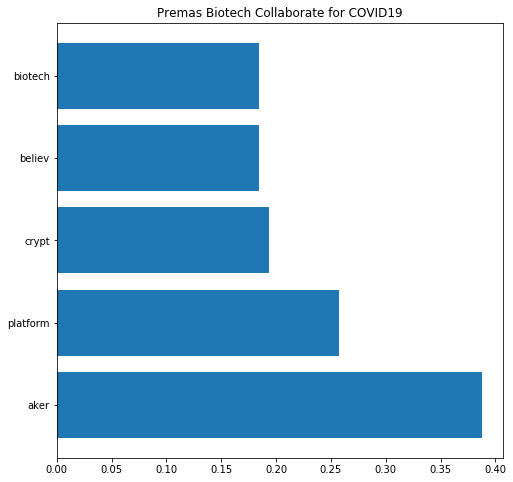

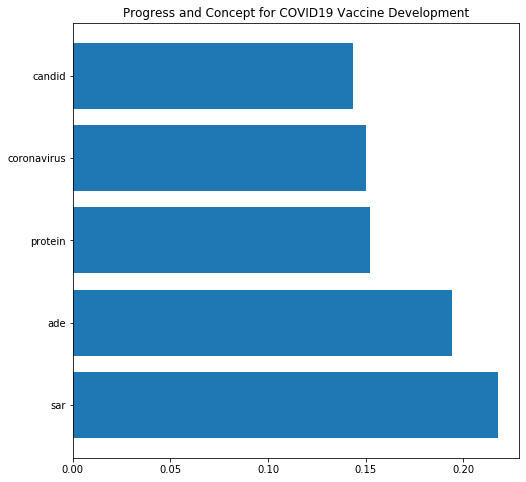

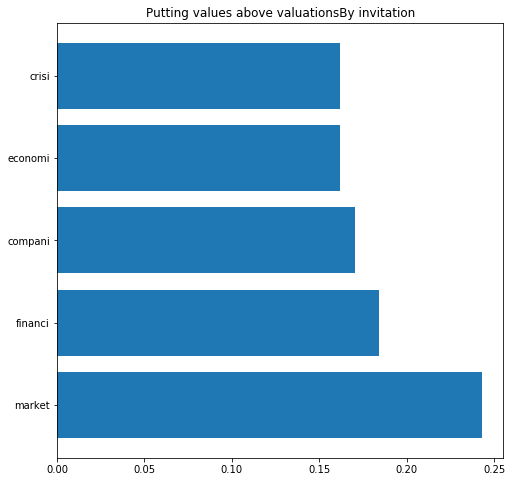

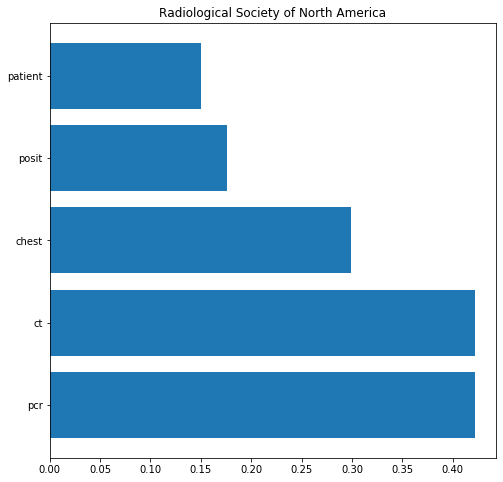

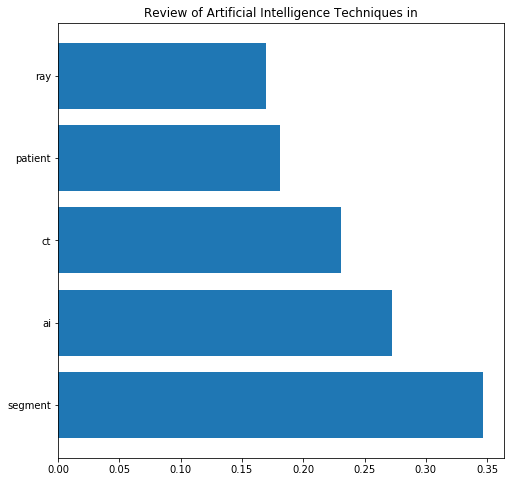

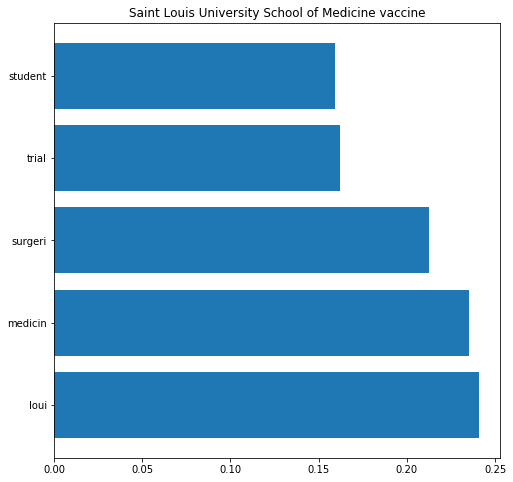

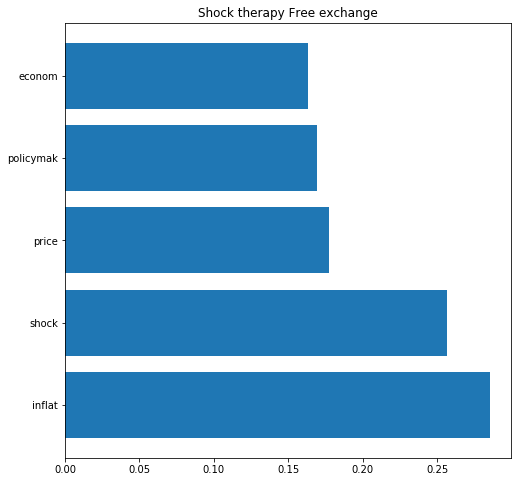

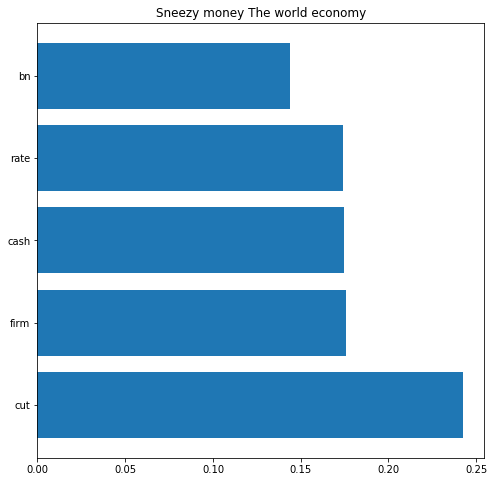

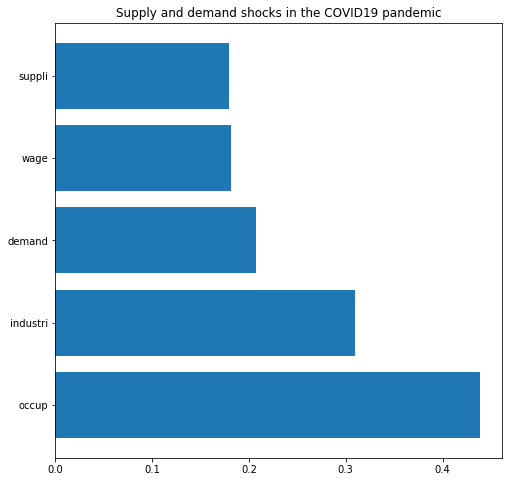

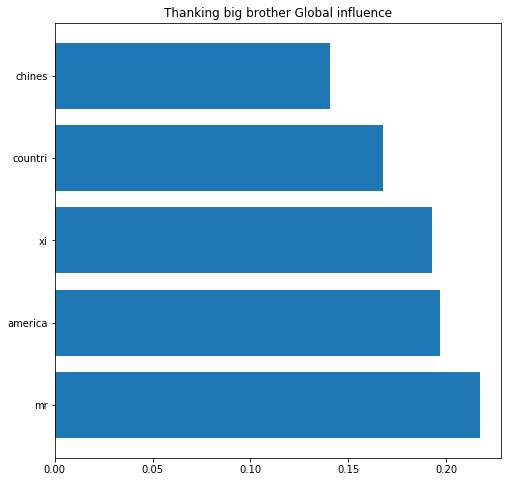

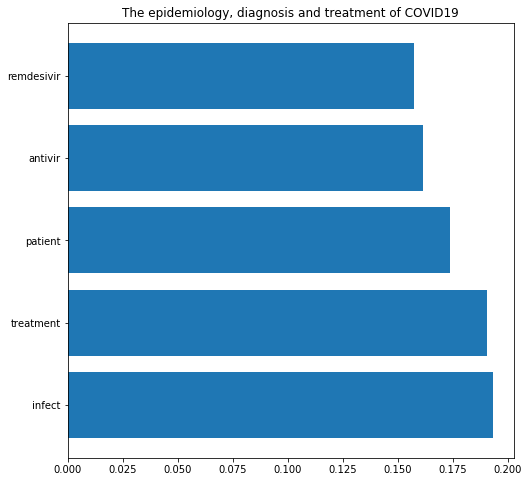

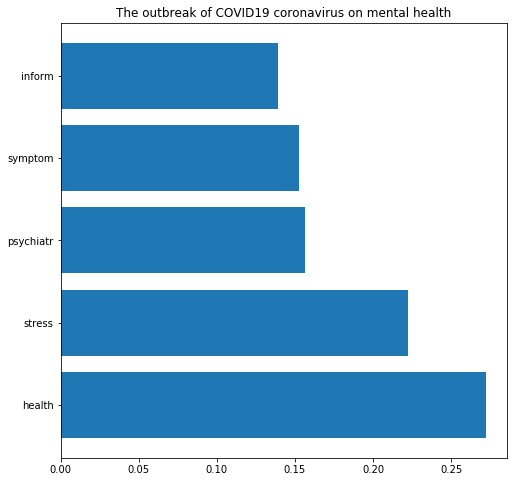

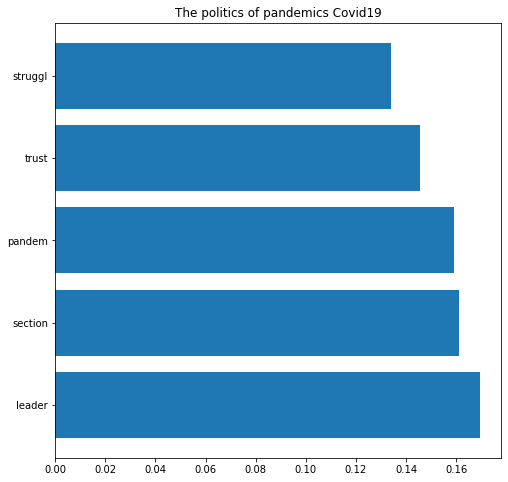

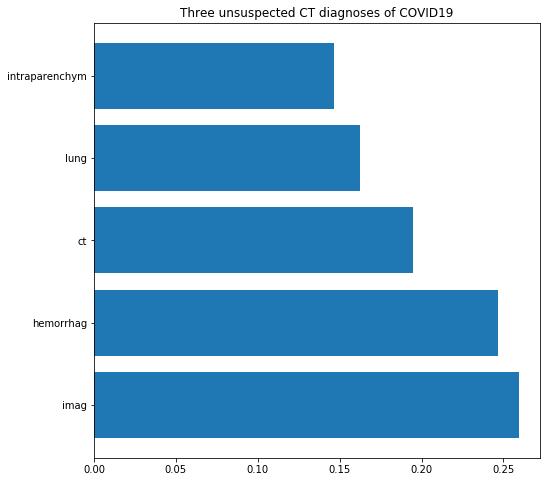

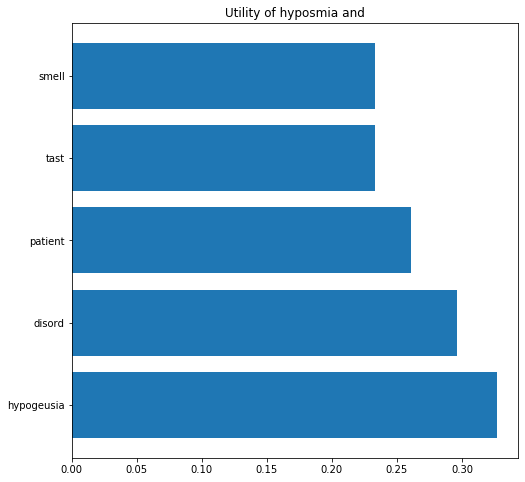

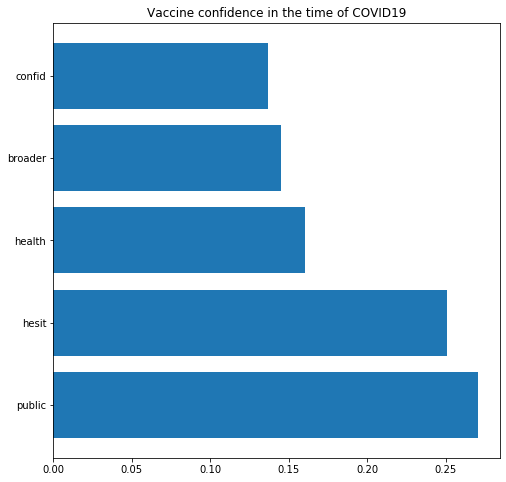

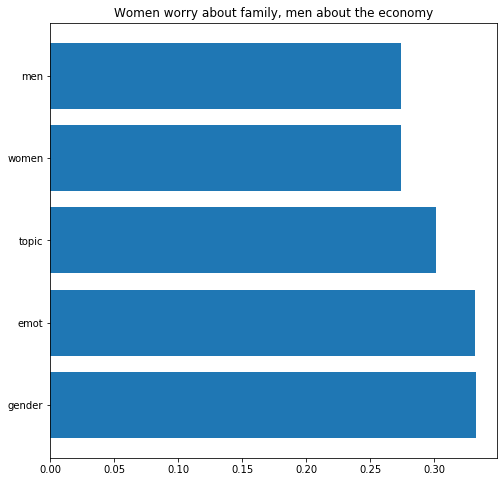

In [11]:
## plot the top 5 word in each file
df_tfidf = pd.DataFrame()
s = 0
a = 0
for i in range(len(weight)):
    arr = []
    x = []
    y =[]
    for j in range(len(terms)):
        arr.append([terms[j],weight[i][j]])
        arr.sort(key = lambda s: s[1])
    for s in range(5):
        x.append(arr[-6:-1][::-1][s][0])
        y.append(arr[-6:-1][::-1][s][1])
    fig = plt.figure(figsize=(8,8)) 
    s += 1
    plt.barh(x, y)
    plt.title(file_name[a][:-4])
    a+=1
    plt.show()

**Explanation:**
* The bar plot shows the top 5 important words in each article, we can see the words are associate with the title of the article.
* It can be used to infer the topic of the article, such as appli, vaacine and dna might be about the development of vaccine using biotechnology method.

#### 2. TF-IDF analysis - similarity

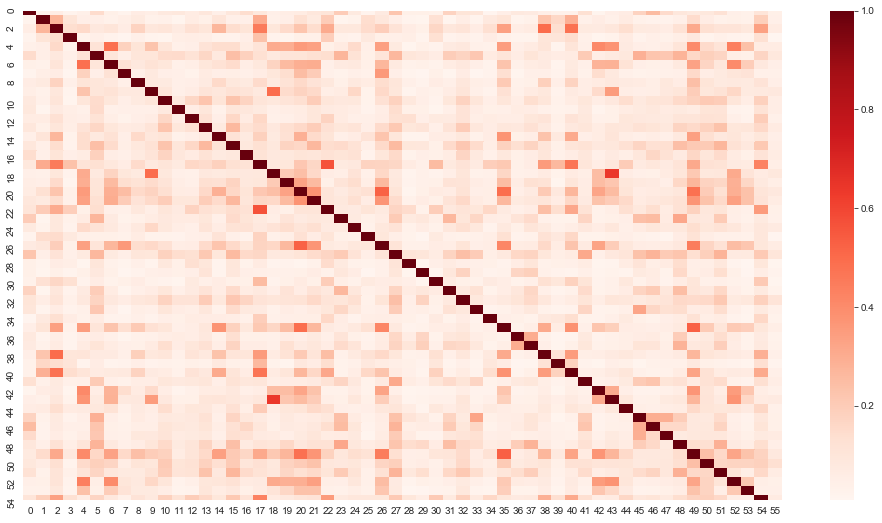

In [21]:
## use similarity heatmap to check the similarity between each file
sim_matrix = cosine_similarity(tfidf_matrix)
fig = plt.figure(figsize=(17,9))
# Plot the matrix
with sns.axes_style("white"):
    ax = sns.heatmap(sim_matrix, cmap="Reds")
    plt.show()

**Explanation:**
* From the similarity plot, some of the papers have higher similarity, some of them are very disimilar with each other.
* so next step we are going to use cluster to find some pattern in the papers.

#### 3. Hierarchy clustering

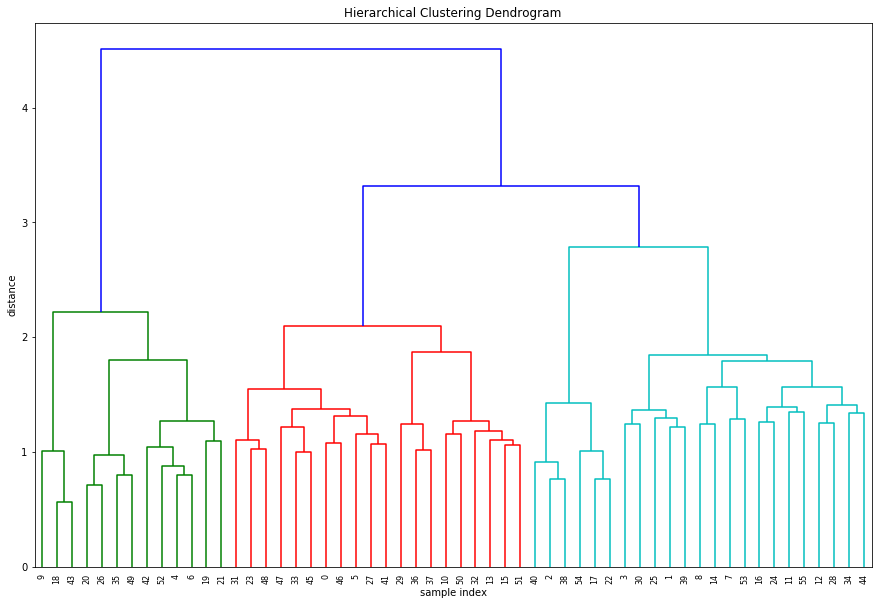

In [22]:
## we use the similarity matrix we get above to caculate the similarity distance
sim_distance=1-sim_matrix

## define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix = ward(sim_distance) 

## plot the dendrogram
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    linkage_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

**Explanation:**
* The result of Hierarchy clustering suggest us that the articles have 3 clusters.
* Since Hierarchy clustering is based on simialrity between each other, it cluster naturally, this can give us insight for k-means clustering for choosing k.


#### 4. k-means Clustering

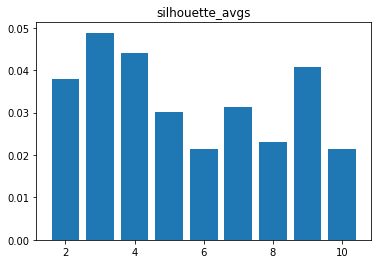

[0.037933142347001, 0.048812209282407516, 0.04394085465768765, 0.03012851216089819, 0.021383144370481225, 0.031190940017719087, 0.02296306233515263, 0.040714809228917424, 0.021500549620192634]


In [23]:
## k-means 
## determine the k
silhouette_avgs = []
ks = range(2, 11)
for k in ks:
    kmeans_fit = KMeans(n_clusters = k).fit(tfidf_matrix)
    cluster_labels = kmeans_fit.labels_
    silhouette_avg = metrics.silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_avgs.append(silhouette_avg)

## plot the find the highest Silhouette Coefficient
## closer to 1 means better
plt.bar(ks, silhouette_avgs)
plt.title("silhouette_avgs")
plt.show()
print(silhouette_avgs)
## also suggest k = 3

In [24]:
## k-means
## set 3 cluster based on the result of the hierarchy clustering and the Elbow point
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
## fit
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [46]:
## read the file name
import os
file_name = []
for name in os.listdir("..\\cov_txt\\"):
    file_name.append(name)

cov_cluster = { 'title': file_name, 'content': text, "processed_doc":cov_nostw, 'cluster': clusters}
cov_cluster_df=pd.DataFrame(cov_cluster, columns = ['title', 'content', "processed_doc",'cluster'])
print(cov_cluster_df.head())
cov_cluster_df['cluster'].value_counts() 
## number of articles per cluster
## cluster1 have 24 articles
## cluster2 have 19 articles
## cluster3 have 13 articles

                                               title  \
0  A BUSINESS FISCAL RESPONSE TO A COVID19 RECESS...   
1  Applied DNA and Takis Biotech Bolster COVID19.txt   
2  Avoiding pitfalls in the pursuit of a COVID19 ...   
3     Biontech, Pfizer Release Details about the.txt   
4      Case Report on Early Diagnosis of COVID19.txt   

                                             content  \
0  the federal government should offer significan...   
1  full text applied dna sciences and takis biote...   
2  as they race to devise a vaccine researchers a...   
3  biontech and pfizer have recently disclosed ad...   
4  coronavirus disease covid outbreak in wuhan ch...   

                                       processed_doc  cluster  
0  federal government offer significant assistanc...        2  
1  full text applied dna sciences takis biotech r...        0  
2  race devise vaccine researchers trying ensure ...        0  
3  biontech pfizer recently disclosed additional ...        0  
4  cor

2    24
1    19
0    13
Name: cluster, dtype: int64

In [26]:
## get the top n terms for each cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
## top 10
def top10_term(n):
    term=[]
    ind=order_centroids[n, :10]    
    for j in ind:
        term.append((terms[j]))
    return term
top10_term(0)
def get_all10term(num_clusters):
    top10terms=[]
    for i in range(num_clusters):
        top10terms.append(top10_term(i))
    return top10terms
top10terms=get_all10term(num_clusters)

# display top 10 terms per cluster
print("Top 10 terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("---Top 10 terms in Cluster %d: " % i, end="\n")
    print(', '.join(top10terms[i]))
    print("---Cluster %d titles:" % i, end='\n')
    for title in cov_cluster_df.loc[cov_cluster_df["cluster"]==i,"title"].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace

Top 10 terms per cluster:
---Top 10 terms in Cluster 0: 
vaccin, develop, candid, trial, antibodi, biontech, protein, cell, immun, compani
---Cluster 0 titles:
 Applied DNA and Takis Biotech Bolster COVID19.txt, Avoiding pitfalls in the pursuit of a COVID19 vaccine.txt, Biontech, Pfizer Release Details about the.txt, Developing Covid19 Vaccines at Pandemic Speed.txt, Ensuring global access to COVID19 vaccines.txt, GSK, Clover Collaborate for COVID19 vaccine.txt, Inovio Pharmaceuticals Expects Human Testing.txt, Milken Institute Introduces COVID19 Treatment.txt, Precision COVID19 Vaccine with Companion Diagnostics.txt, Premas Biotech Collaborate for COVID19.txt, Progress and Concept for COVID19 Vaccine Development.txt, Saint Louis University School of Medicine vaccine.txt, Vaccine confidence in the time of COVID19.txt,

---Top 10 terms in Cluster 1: 
patient, ct, sar, imag, infect, use, test, pcr, diagnosi, lung
---Cluster 1 titles:
 Case Report on Early Diagnosis of COVID19.txt, Clinic

In [51]:
## create dataframe for better visvisualization
df = pd.DataFrame(columns=['cluster1', 'cluster2', 'cluster3'])
df["cluster1"] = top10terms[0]
df["cluster2"] = top10terms[1]
df["cluster3"] = top10terms[2]
df

,cluster1,cluster2,cluster3
0,vaccin,patient,china
1,develop,ct,countri
2,candid,sar,economi
3,trial,imag,govern
4,antibodi,infect,econom
5,biontech,use,polici
6,protein,test,health
7,cell,pcr,shock
8,immun,diagnosi,peopl
9,compani,lung,suppli


**Explanation:**
* Based on the barplot, it also indicates the k=3, this is in accordance with the result of the Hierarchy clustering result.
* There are 13 articles in cluster 1, 19 in cluster 2, 24 in cluster 3.
* The most 10 terms in cluster 1 indicated the articles might be about vaccine development, the second might be doagnosis, the third is about economy and politics 

#### 5. Multidimensional scaling

In [28]:
# Convert the distance matrix into a two dimensional array using multidimensional scaling.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=123)
## fit the sim_distance we get from above 
pos = mds.fit_transform(sim_distance)  # shape (n_components, n_samples)
## get the x and y
xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))

<class 'numpy.ndarray'>


In [29]:
## set up colors per clusters using a dict
cluster_col = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

## set up cluster names using a dict
cluster_nm = {0: 'vaccine', 
                 1: 'diagnosis',                  
                 2: 'economy', 
                 }
%matplotlib inline 

## create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=cov_cluster_df['cluster'],title=cov_cluster_df['title']))

## group by cluster
groups = df.groupby('label')
## check it
df.head()

,x,y,label,title
0,0.637576,0.315940,2,A BUSINESS FISCAL RESPONSE TO A COVID19 RECESS...
1,-0.659321,-0.245699,0,Applied DNA and Takis Biotech Bolster COVID19.txt
2,-0.319757,-0.215916,0,Avoiding pitfalls in the pursuit of a COVID19 ...
3,-0.651095,-0.405106,0,"Biontech, Pfizer Release Details about the.txt"
4,0.240635,-0.498748,1,Case Report on Early Diagnosis of COVID19.txt


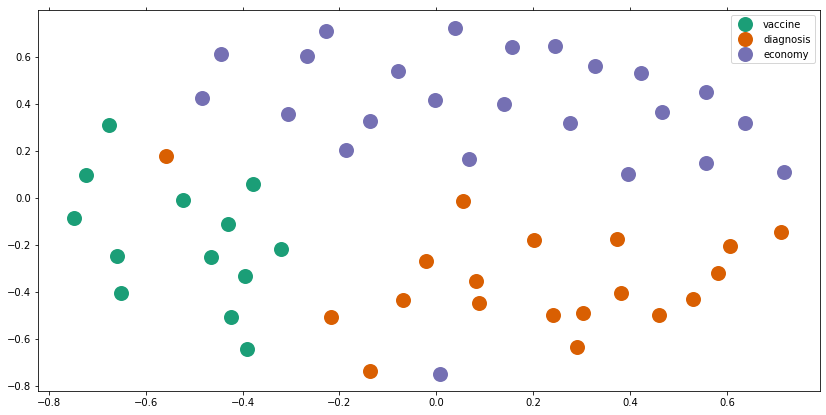

In [30]:
# set up plot
fig, ax = plt.subplots(figsize=(14, 7)) # set size

# iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=15, # ms=marker size
            label=cluster_nm[name], color=cluster_col[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # apply to the x-axis 
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

    
## show the plot
plt.show() 

**Explanation:**
* DMS is a way to visualize the distance of the variables.
* From the plot the three clusters are not separated well, one diagnosis is in the vaccine cluster and one economy is in the diagnosis.

#### 6. Topic modeling

In [31]:
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

## remove proper names
preprocess = [strip_proppers(doc) for doc in cov_nostw]

## tokenize
tokenized_text = [tokenize_and_stem(text) for text in preprocess]

## remove stop words
stopwords = set(nltk.corpus.stopwords.words('english'))
texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

## create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

## remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

## convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA, set 3 topic
lda = models.LdaModel(corpus, num_topics=3,
                      id2word=dictionary, 
                      update_every=5, 
                      chunksize=10000, 
                      passes=100)

lda.show_topics()

[(0,
  '0.009*"china" + 0.007*"vaccin" + 0.007*"polici" + 0.006*"pandem" + 0.006*"govern" + 0.005*"countri" + 0.005*"public" + 0.005*"global" + 0.005*"econom" + 0.005*"peopl"'),
 (1,
  '0.014*"imag" + 0.010*"use" + 0.009*"shock" + 0.007*"model" + 0.007*"differ" + 0.007*"occup" + 0.007*"industri" + 0.007*"patient" + 0.007*"data" + 0.007*"work"'),
 (2,
  '0.016*"sar" + 0.014*"patient" + 0.011*"vaccin" + 0.011*"infect" + 0.009*"test" + 0.008*"use" + 0.007*"develop" + 0.007*"coronavirus" + 0.006*"clinic" + 0.006*"diseas"')]

In [32]:
## create dataframe for better visvisualization
topics_matrix = lda.show_topics(formatted=False, num_words=10)
topics_matrix = np.array(topics_matrix)
word0 = []
word1 = []
word2 = []
for i in range(10):
    word0.append(topics_matrix[0][1][i][0])
    word1.append(topics_matrix[1][1][i][0])
    word2.append(topics_matrix[2][1][i][0])
topic_df = pd.DataFrame(columns=['topic1', 'topic2', 'topic3'])
topic_df["topic1"] = word0
topic_df["topic2"] = word1
topic_df["topic3"] = word2
topic_df

,topic1,topic2,topic3
0,china,imag,sar
1,vaccin,use,patient
2,polici,shock,vaccin
3,pandem,model,infect
4,govern,differ,test
5,countri,occup,use
6,public,industri,develop
7,global,patient,coronavirus
8,econom,data,clinic
9,peopl,work,diseas


**Explanation:**
* LDA is a probalistic model and it computes the probabilities and assign weights to each word, but it has the draw back since the number of topic have to be provided.
* Based on the result of cluster, we choose number of topic as 3.
* From the top 10 words, we can see topic 1 is about politic and economy, about society, topic 2 is about image and patient, it is about giagnosis, topic 3 is about vaccine.

#### 7. PCA

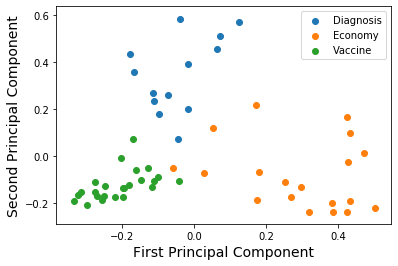

In [33]:
## reduce to 2 dimention
pca = PCA(n_components= 2)
## fit the TF-IDF 
weight_pca = pca.fit_transform(weight)
## transfer to dataframe to plot it
new_df = pd.DataFrame(weight_pca)
new_df[2] = df['label']
lab = []
for i in range(len(new_df)):
    if new_df[2][i] == 0:
        lab.append('Diagnosis')
    elif new_df[2][i] == 1:
        lab.append('Economy')
    elif new_df[2][i] == 2:
        lab.append('Vaccine')
new_df[3] = lab
## plot with label
dia = new_df[new_df[3] == 'Diagnosis']
eco = new_df[new_df[3] == 'Economy']
vac = new_df[new_df[3] == 'Vaccine']
plt.scatter(dia[0], dia[1], label='Diagnosis')
plt.scatter(eco[0], eco[1], label='Economy') 
plt.scatter(vac[0], vac[1], label='Vaccine')
plt.xlabel("First Principal Component",fontsize=14) 
plt.ylabel("Second Principal Component",fontsize=14) 
plt.legend() 
plt.show()

**Explanation:**
* PCA is used to reduce the dimension of the data and visualize the distribution.
* From the PCA plot, the three clusters are better separated than the DMS. 

###  Summary


1. From the wordcloud, word frequency, TF-IDF, we know that there are some word keep appear, however, there are still some different word appear in each file. Therefore, these articles are focus on different topic.
2. According to the result of Hierarchy clustering, we know that we can seperate the articles into three cluster.
3. We use k-means to cluster them into three cluster and grab out the top 10 word in each cluster.
4. We define three cluster into vaccine, diagnosis, economy by the word and topic in each cluster.
5. We use Multidimensional scaling to convert the dist matrix into a 2-dimensional and visulize it, compare to the another plot we use PCA to reduce the TF-IDF dimention, the out come of these two are pretty similar, only a few point are different, but PCA seperate the article more better.
6. We also use LDA to get the words and its probability that defines three topic. And the word LDA get are almost as same as the word we get in k-means 

### Issues / Improvements

identitify issues and propose potential solutions to improve your results
1. The problem of pdf format convert to the file that python can easily read

2. In the future we will explore better tool to deal with pdf file and try other method to get the summary of each article, which can provide insight to researchers.

###  References
   - http://brandonrose.org/clustering#Multidimensional-scaling
   - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
   - Dayeen F., Sharma A.S., Derrible S. A text mining analysis of the climate change literature in industrial ecology, Journal       of Industrial Ecology, 2020: 1-9
   - Bhanot N., Singh H, Sharma D. Python vs. R: A Text Mining Approach for analyzing the Research Trends in Scopus Database.      arXiv:1911.08271
   - Contiero B., Cozzi G, Karpf L. Pain in Pig Production: Text Mining Analysis of the Scientific Literature, Journal of    Agricultural and Environmental Ethics, 2019, 32:401–412 
   - Nuzzoa A., Mulasa F., Gabetta M. Text Mining approaches for Automated Literature Knowledge Extraction and Representation, Stud Health Technol Inform. 2010;160(2):954-8.
   